<a href="https://colab.research.google.com/github/DiegoAunta/EFM---Efecto-Fotoelectrico/blob/main/INPractica2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install uncertainties

#Preparación

Todos los espectros + Espectros sin fondo

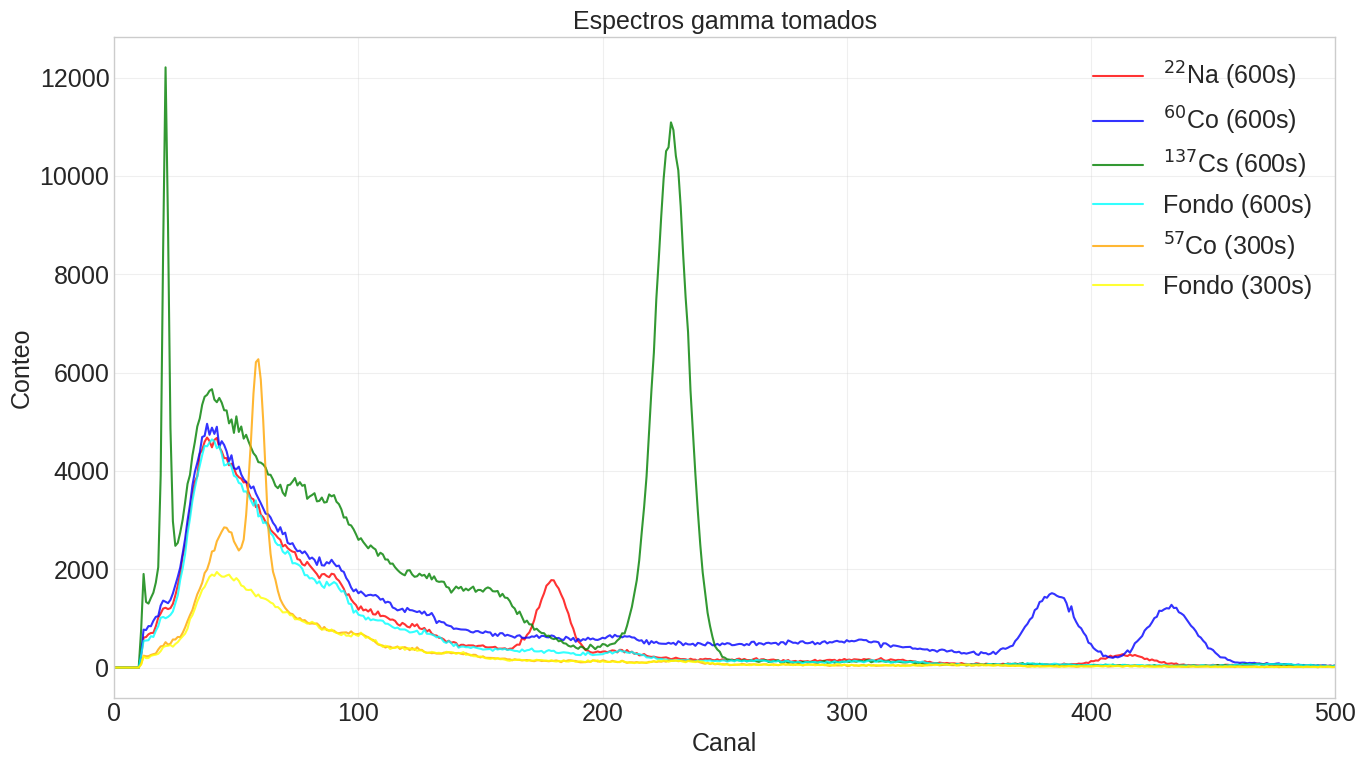

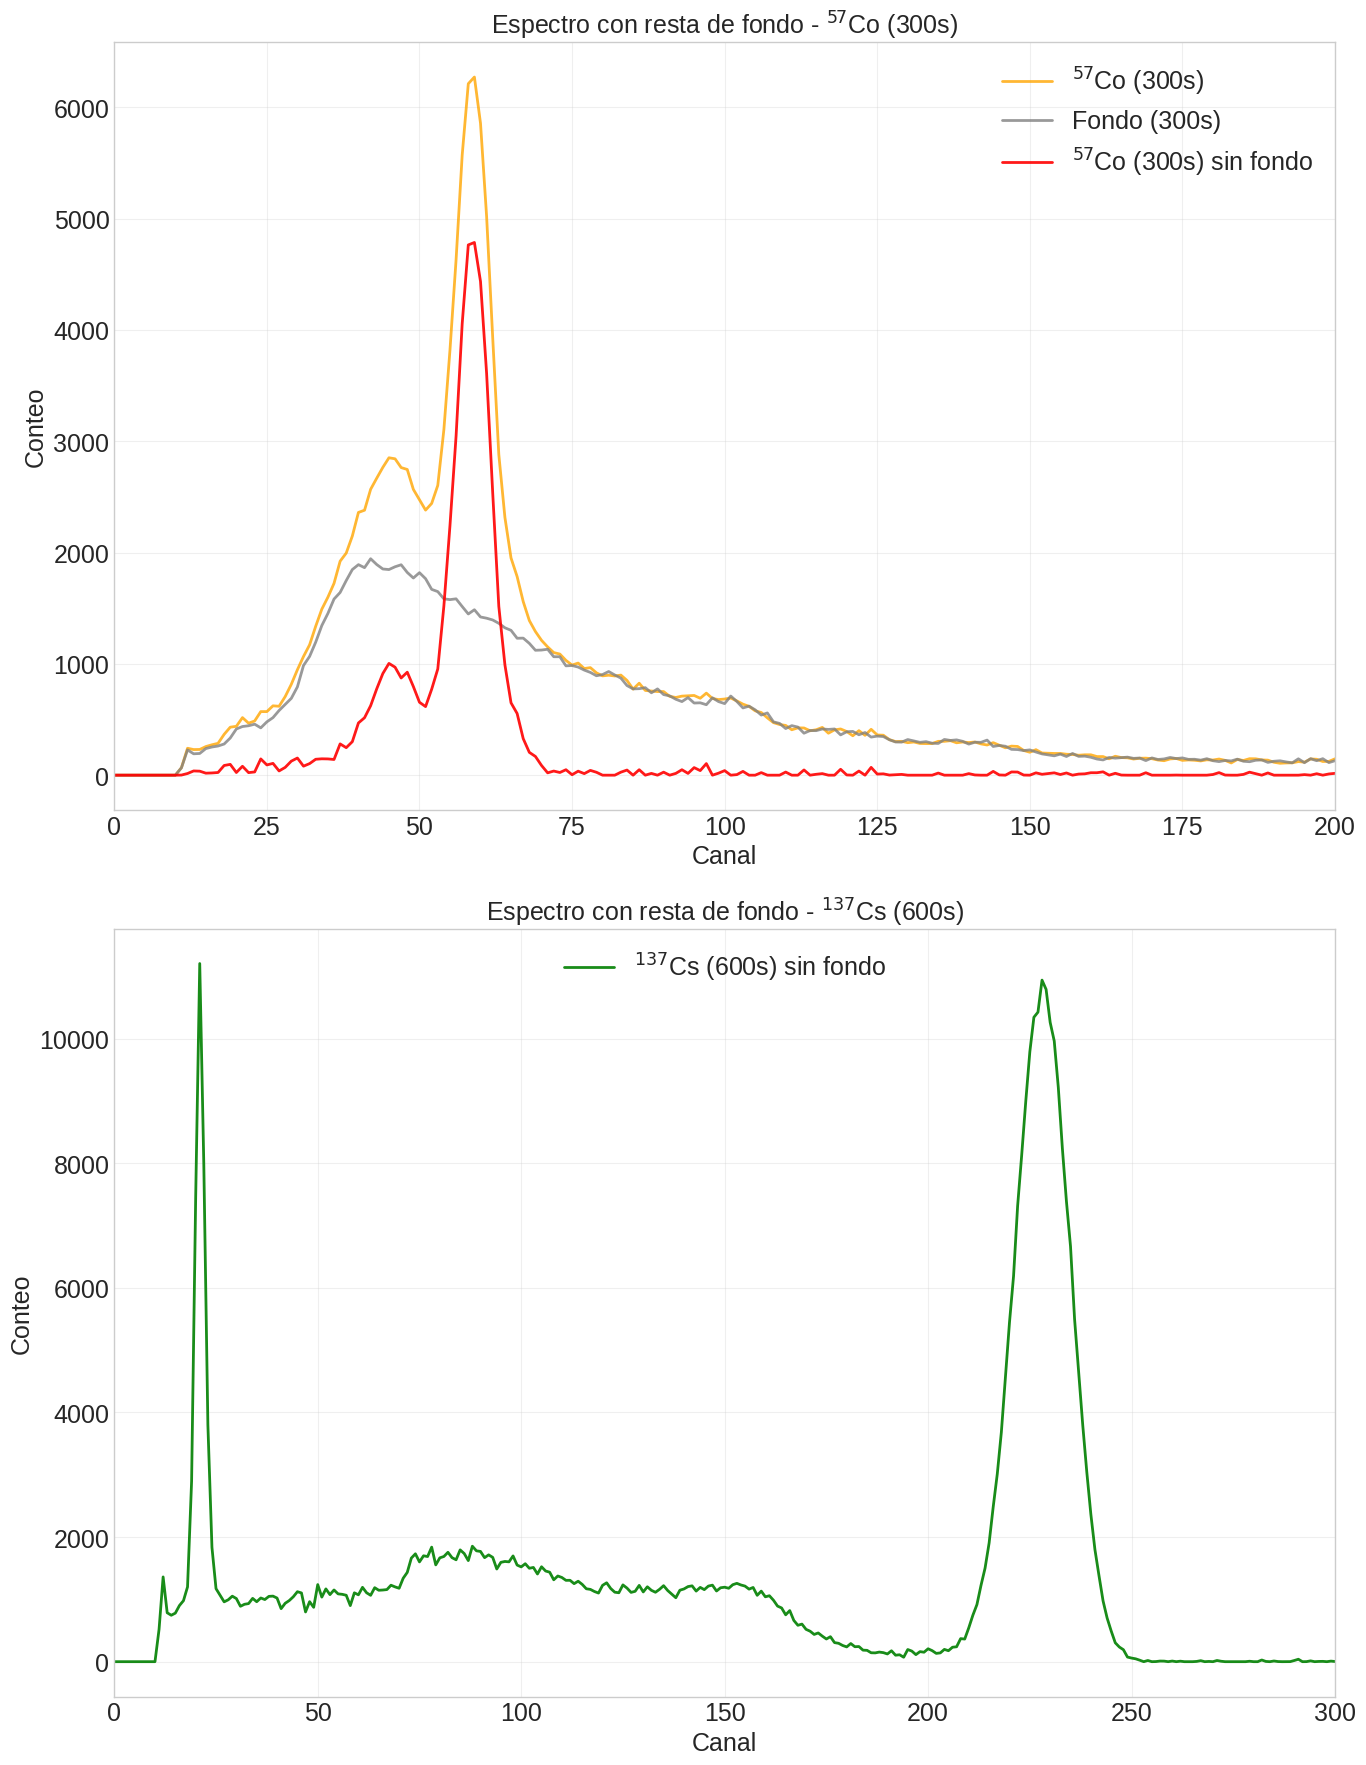

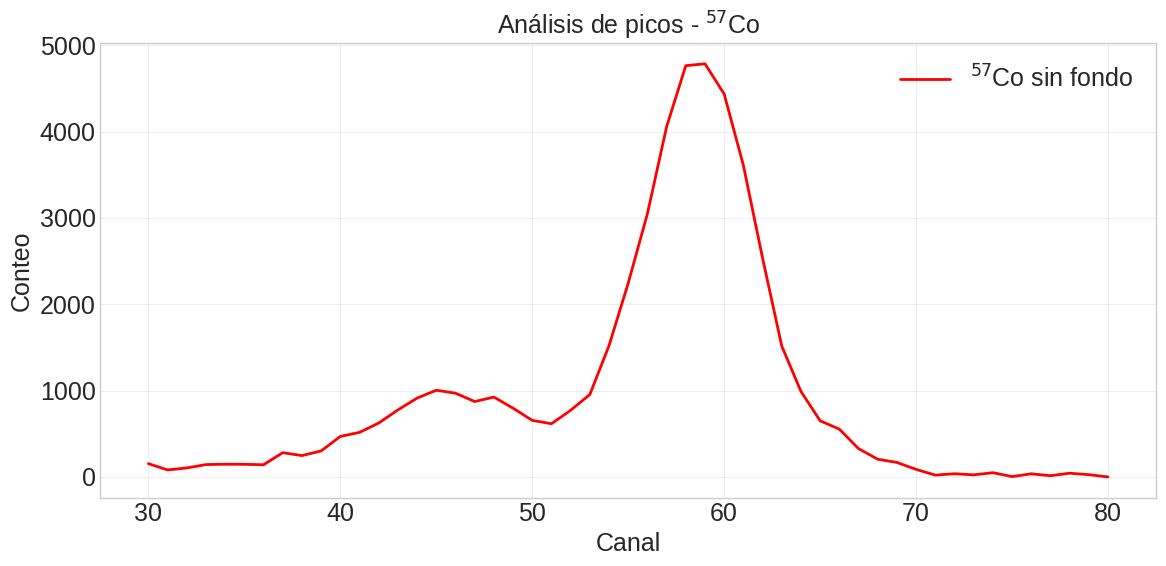

In [ ]:
pip install uncertainties
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficas científicas
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (12, 8)

# Nombres de los archivos .dat según la guía
archivos = [
    "NaI_22Na_600s.dat",
    "NaI_60Co_600s.dat",
    "NaI_137Cs_600s.dat",
    "NaI_Fondo_600s.dat",
    "NaI_57Co_300s.dat",
    "NaI_Fondo_300s.dat"
]

# Etiquetas para cada archivo
labels = [
    "$^{22}$Na (600s)",
    "$^{60}$Co (600s)",
    "$^{137}$Cs (600s)",
    "Fondo (600s)",
    "$^{57}$Co (300s)",
    "Fondo (300s)"
]

# Colores distintos para cada espectro
colores = ['red', 'blue', 'green', 'cyan', 'orange', 'yellow']

# Función para leer archivos .dat
def leer_espectro(archivo):
    #Lee archivo
    try:
        # Método 1: leer como CSV con separador de espacios
        try:
            data = pd.read_csv(archivo, delim_whitespace=True, header=None, comment='#')
        except:
            # Método 2: leer como texto y procesar manualmente
            with open(archivo, 'r') as f:
                lines = f.readlines()

            # Filtrar líneas que parecen contener datos numéricos
            data_lines = []
            for line in lines:
                if line.strip() and not line.strip().startswith('#'):
                    elements = line.split()
                    numeric_elements = []
                    for elem in elements:
                        try:
                            float(elem)
                            numeric_elements.append(elem)
                        except:
                            continue
                    if numeric_elements:
                        data_lines.append(numeric_elements)

            if data_lines:
                max_cols = max(len(line) for line in data_lines)
                for i in range(len(data_lines)):
                    data_lines[i] = data_lines[i] + ['0'] * (max_cols - len(data_lines[i]))
                data = pd.DataFrame(data_lines)
            else:
                return None, None

        # Convertir todas las columnas a numérico
        for col in data.columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')

        # Eliminar filas con todos NaN
        data = data.dropna(how='all')

        # Determinar estructura de datos
        if data.shape[1] >= 2:
            canal = data.iloc[:, 0].values
            conteo = data.iloc[:, 1].values
        else:
            canal = np.arange(len(data))
            conteo = data.iloc[:, 0].values

        return canal, conteo

    except Exception as e:
        print(f"Error leyendo {archivo}: {e}")
        return None, None

# Leer todos los espectros
espectros = {}
for i, (archivo, label, color) in enumerate(zip(archivos, labels, colores)):
    canal, conteo = leer_espectro(archivo)
    if canal is not None and conteo is not None:
        espectros[archivo] = {'canal': canal, 'conteo': conteo, 'label': label, 'color': color}

# Gráfica Todos los espectros
plt.figure(figsize=(14, 8))
for archivo in archivos:
    if archivo in espectros:
        datos = espectros[archivo]
        plt.plot(datos['canal'], datos['conteo'], lw=1.5,
                label=datos['label'], color=datos['color'], alpha=0.8)

plt.xlabel("Canal", fontsize=18)
plt.ylabel("Conteo", fontsize=18)
plt.title("Espectros gamma tomados", fontsize=18)
plt.grid(alpha=0.3)
plt.legend(fontsize=18)
plt.xlim(0, 500)
plt.tight_layout()
plt.show()

# interpolar espectros
def interpolar_a_grilla_comun(canal1, conteo1, canal2, conteo2):
    """Interpola dos espectros a una grilla de canales común"""
    canal_comun = np.arange(0, 1024)
    conteo1_interp = np.interp(canal_comun, canal1, conteo1, left=0, right=0)
    conteo2_interp = np.interp(canal_comun, canal2, conteo2, left=0, right=0)
    return canal_comun, conteo1_interp, conteo2_interp

# Restar fondos y crear espectros resta
if "NaI_57Co_300s.dat" in espectros and "NaI_Fondo_300s.dat" in espectros:
    canal_57Co = espectros["NaI_57Co_300s.dat"]['canal']
    conteo_57Co = espectros["NaI_57Co_300s.dat"]['conteo']
    canal_fondo300 = espectros["NaI_Fondo_300s.dat"]['canal']
    conteo_fondo300 = espectros["NaI_Fondo_300s.dat"]['conteo']

    canal_comun, conteo_57Co_interp, conteo_fondo300_interp = interpolar_a_grilla_comun(
        canal_57Co, conteo_57Co, canal_fondo300, conteo_fondo300
    )
    resta_57Co = np.maximum(conteo_57Co_interp - conteo_fondo300_interp, 0)
    espectros["57Co_resta"] = {'canal': canal_comun, 'conteo': resta_57Co, 'label': '$^{57}$Co (300s) sin fondo'}

if "NaI_137Cs_600s.dat" in espectros and "NaI_Fondo_600s.dat" in espectros:
    canal_137Cs = espectros["NaI_137Cs_600s.dat"]['canal']
    conteo_137Cs = espectros["NaI_137Cs_600s.dat"]['conteo']
    canal_fondo600 = espectros["NaI_Fondo_600s.dat"]['canal']
    conteo_fondo600 = espectros["NaI_Fondo_600s.dat"]['conteo']

    canal_comun, conteo_137Cs_interp, conteo_fondo600_interp = interpolar_a_grilla_comun(
        canal_137Cs, conteo_137Cs, canal_fondo600, conteo_fondo600
    )
    resta_137Cs = np.maximum(conteo_137Cs_interp - conteo_fondo600_interp, 0)
    espectros["137Cs_resta"] = {'canal': canal_comun, 'conteo': resta_137Cs, 'label': '$^{137}$Cs (600s) sin fondo'}

# Gráfica Resta de fondos
plt.figure(figsize=(14, 18))

plt.subplot(2, 1, 1)
if "57Co_resta" in espectros:
    canal_comun = espectros["57Co_resta"]['canal']
    plt.plot(canal_comun, conteo_57Co_interp, 'orange', lw=2, label='$^{57}$Co (300s)', alpha=0.8)
    plt.plot(canal_comun, conteo_fondo300_interp, 'gray', lw=2, label='Fondo (300s)', alpha=0.8)
    plt.plot(canal_comun, resta_57Co, 'red', lw=2, label='$^{57}$Co (300s) sin fondo', alpha=0.9)
    plt.xlabel("Canal")
    plt.ylabel("Conteo")
    plt.title("Espectro con resta de fondo - $^{57}$Co (300s)", fontsize=18)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xlim(0, 200)

plt.subplot(2, 1, 2)
if "137Cs_resta" in espectros:
    canal_comun = espectros["137Cs_resta"]['canal']
    plt.plot(canal_comun, resta_137Cs, 'green', lw=2, label='$^{137}$Cs (600s) sin fondo', alpha=0.9)
    plt.xlabel("Canal")
    plt.ylabel("Conteo")
    plt.title("Espectro con resta de fondo - $^{137}$Cs (600s)", fontsize=18)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xlim(0, 300)

plt.tight_layout()
plt.show()


if "57Co_resta" in espectros:
    canal = espectros["57Co_resta"]['canal']
    resta_57Co = espectros["57Co_resta"]['conteo']

    # Graficar región de interés del 57Co
    plt.figure(figsize=(12, 6))
    mask = (canal >= 30) & (canal <= 80)
    canal_roi = canal[mask]
    resta_roi = resta_57Co[mask]

    plt.plot(canal_roi, resta_roi, 'red', lw=2, label='$^{57}$Co sin fondo')

    plt.xlabel("Canal")
    plt.ylabel("Conteo")
    plt.title("Análisis de picos - $^{57}$Co", fontsize=18)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



#Identificacion de picos


$^{137}$Cs:
----------------------------------------
  32.8 keV (X ray): Canal 21.0 (Energía: 32.8 keV)
  661.7 keV: Canal 228.0 (Energía: 661.7 keV)


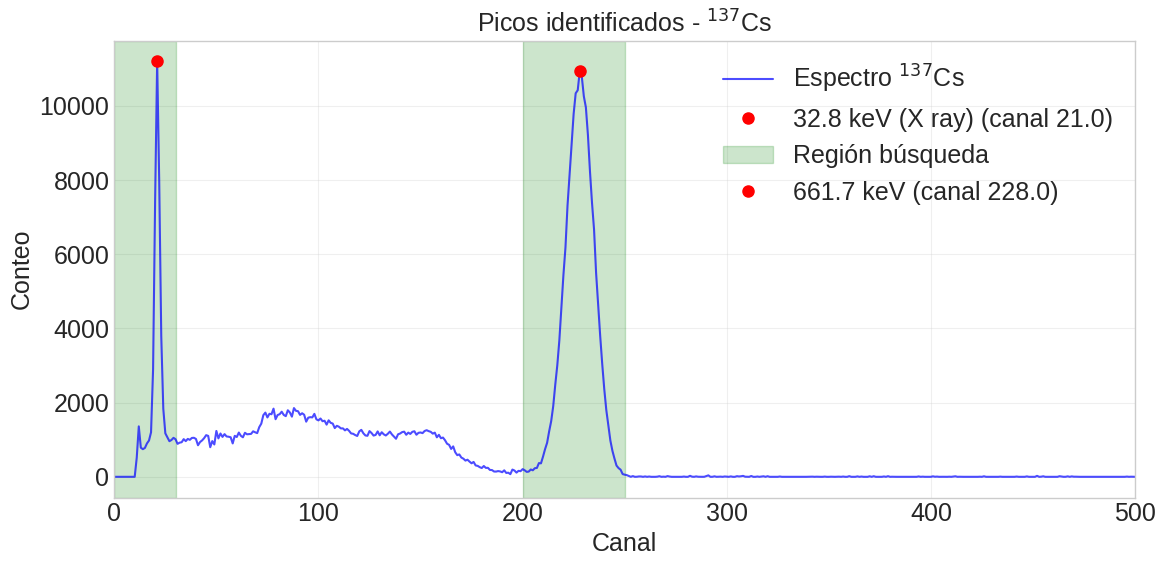


$^{60}$Co:
----------------------------------------
  1173.2 keV: Canal 384.0 (Energía: 1173.2 keV)
  1332.5 keV: Canal 433.0 (Energía: 1332.5 keV)


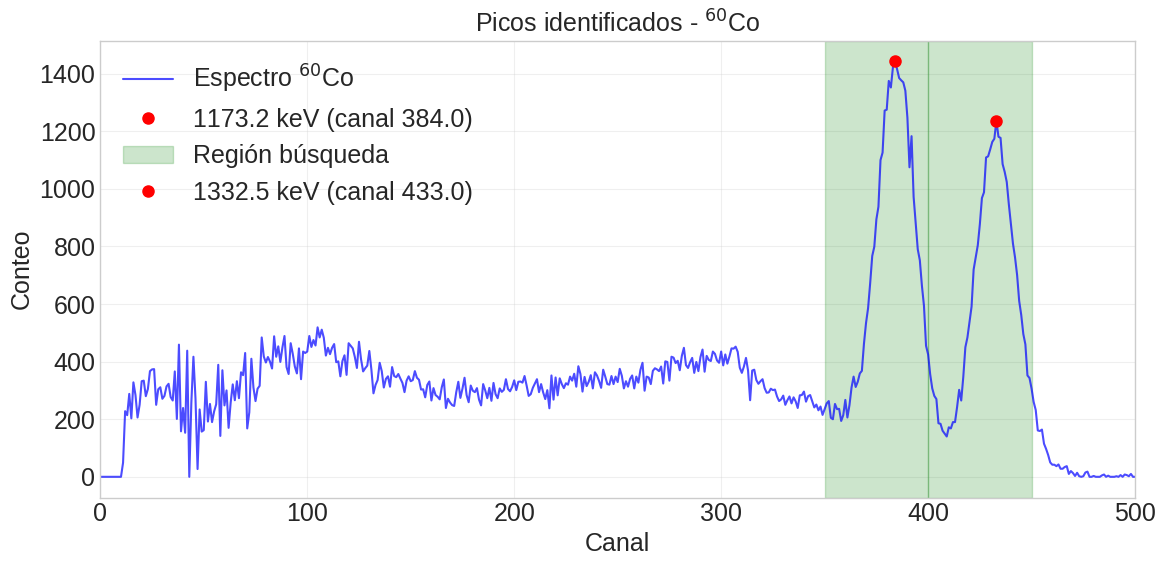


$^{22}$Na:
----------------------------------------
  511.0 keV: Canal 179.0 (Energía: 511.0 keV)
  1274.5 keV: Canal 416.0 (Energía: 1274.5 keV)


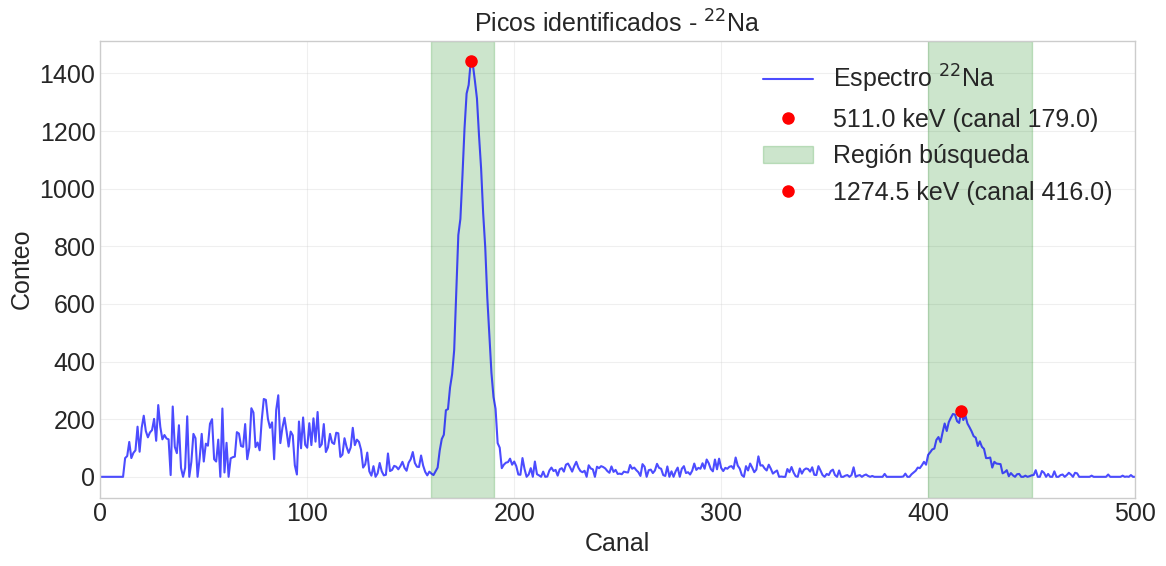


$^{57}$Co:
----------------------------------------
  122.1 keV: Canal 58.0 (Energía: 122.1 keV)
  136.5 keV: Canal 59.0 (Energía: 136.5 keV)


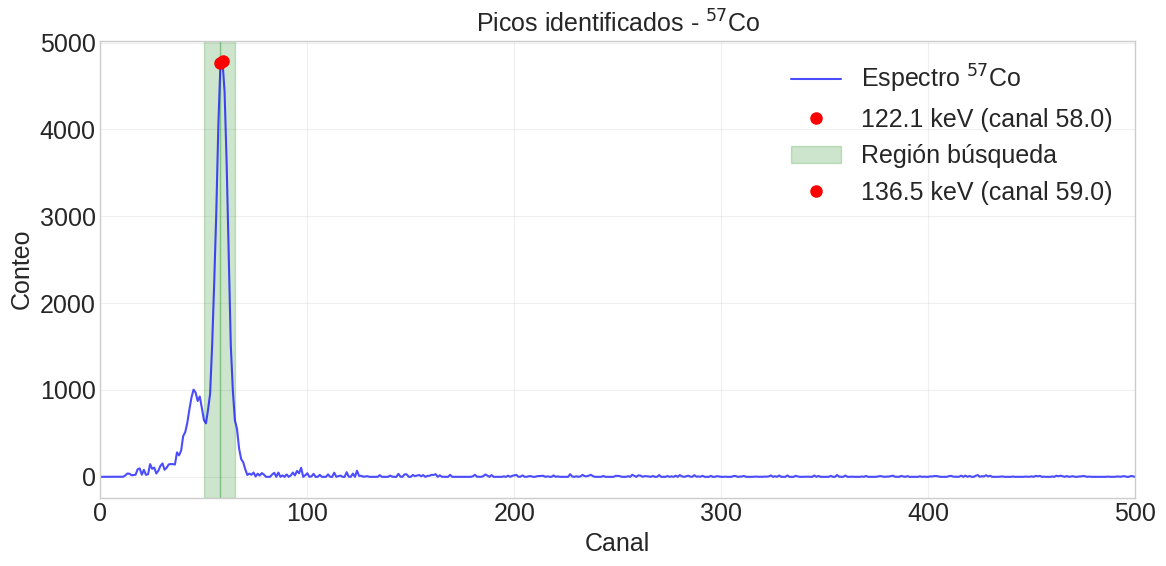

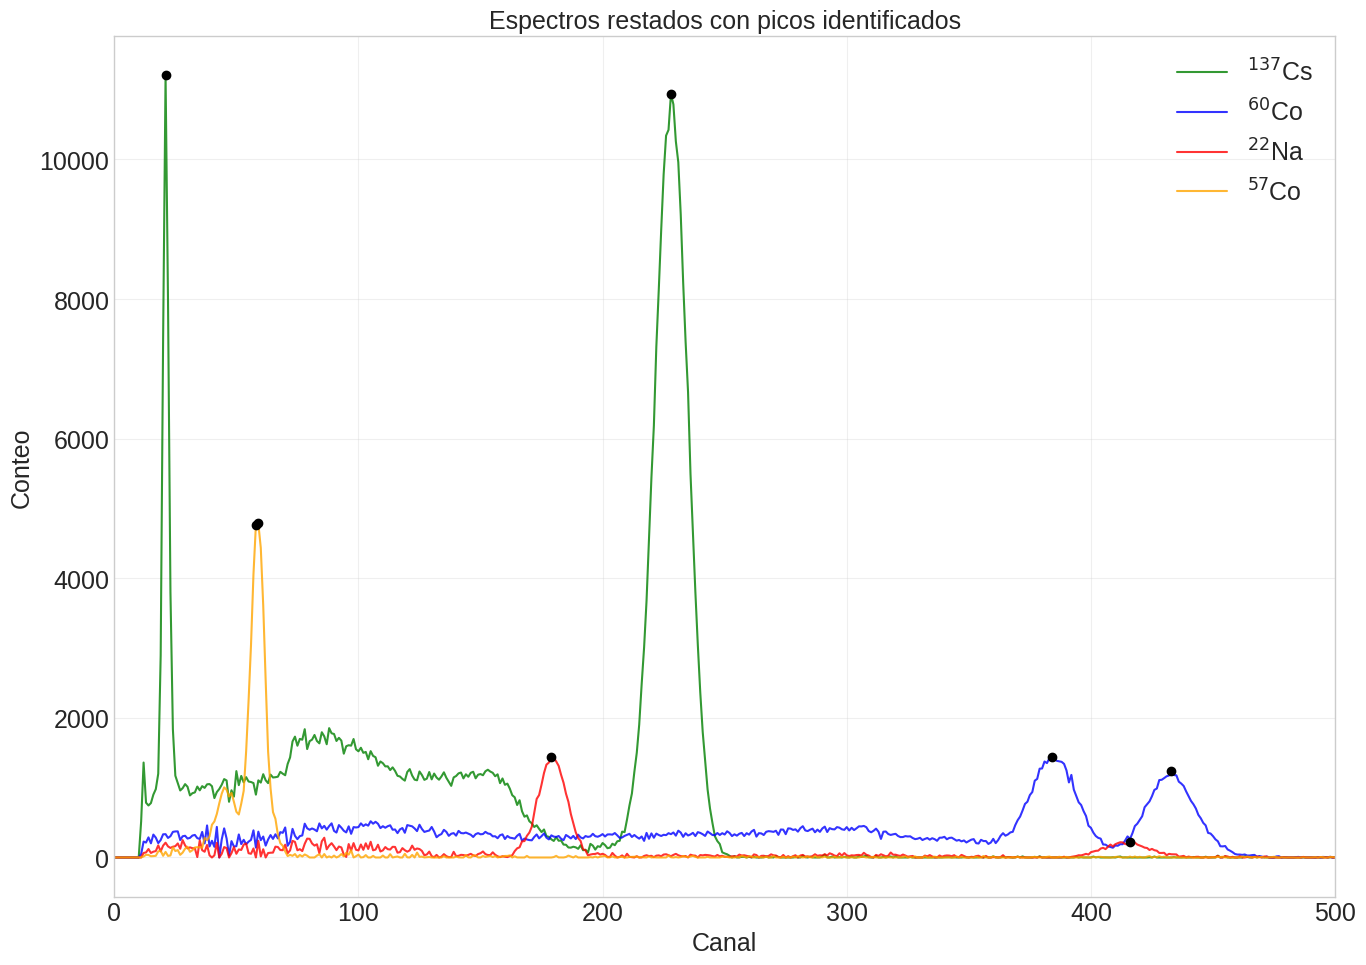

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficas científicas
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (12, 8)

# Nombres de los archivo
archivos = [
    "NaI_22Na_600s.dat",
    "NaI_60Co_600s.dat",
    "NaI_137Cs_600s.dat",
    "NaI_Fondo_600s.dat",
    "NaI_57Co_300s.dat",
    "NaI_Fondo_300s.dat"
]

labels = [
    "$^{22}$Na (600s)",
    "$^{60}$Co (600s)",
    "$^{137}$Cs (600s)",
    "Fondo (600s)",
    "$^{57}$Co (300s)",
    "Fondo (300s)"
]

# Colores distintos para cada espectro
colores = ['red', 'blue', 'green', 'gray', 'orange', 'black']

# leer archivos
def leer_espectro(archivo):
    try:
        try:
            data = pd.read_csv(archivo, delim_whitespace=True, header=None, comment='#')
        except:

            with open(archivo, 'r') as f:
                lines = f.readlines()

            data_lines = []
            for line in lines:
                if line.strip() and not line.strip().startswith('#'):
                    elements = line.split()
                    numeric_elements = []
                    for elem in elements:
                        try:
                            float(elem)
                            numeric_elements.append(elem)
                        except:
                            continue
                    if numeric_elements:
                        data_lines.append(numeric_elements)

            if data_lines:
                max_cols = max(len(line) for line in data_lines)
                for i in range(len(data_lines)):
                    data_lines[i] = data_lines[i] + ['0'] * (max_cols - len(data_lines[i]))
                data = pd.DataFrame(data_lines)
            else:
                return None, None

        # Convertir todas las columnas a numérico
        for col in data.columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')

        # Eliminar filas con todos NaN
        data = data.dropna(how='all')

        if data.shape[1] >= 2:
            canal = data.iloc[:, 0].values
            conteo = data.iloc[:, 1].values
        else:
            canal = np.arange(len(data))
            conteo = data.iloc[:, 0].values

        return canal, conteo

    except Exception as e:
        print(f"Error leyendo {archivo}: {e}")
        return None, None

# Leer todos los espectros
espectros = {}
for i, (archivo, label, color) in enumerate(zip(archivos, labels, colores)):
    canal, conteo = leer_espectro(archivo)
    if canal is not None and conteo is not None:
        espectros[archivo] = {'canal': canal, 'conteo': conteo, 'label': label}

# interpolar espectros
def interpolar_a_grilla_comun(canal1, conteo1, canal2, conteo2):
    canal_comun = np.arange(0, 1024)
    conteo1_interp = np.interp(canal_comun, canal1, conteo1, left=0, right=0)
    conteo2_interp = np.interp(canal_comun, canal2, conteo2, left=0, right=0)
    return canal_comun, conteo1_interp, conteo2_interp


# Para fuentes de 600s
fuentes_600s = ["NaI_22Na_600s.dat", "NaI_60Co_600s.dat", "NaI_137Cs_600s.dat"]
for fuente in fuentes_600s:
    if fuente in espectros and "NaI_Fondo_600s.dat" in espectros:
        canal_fuente = espectros[fuente]['canal']
        conteo_fuente = espectros[fuente]['conteo']
        canal_fondo = espectros["NaI_Fondo_600s.dat"]['canal']
        conteo_fondo = espectros["NaI_Fondo_600s.dat"]['conteo']

        canal_comun, conteo_fuente_interp, conteo_fondo_interp = interpolar_a_grilla_comun(
            canal_fuente, conteo_fuente, canal_fondo, conteo_fondo
        )
        resta = np.maximum(conteo_fuente_interp - conteo_fondo_interp, 0)
        nombre_resta = fuente.replace('.dat', '_resta')
        espectros[nombre_resta] = {'canal': canal_comun, 'conteo': resta, 'label': fuente.replace('.dat', ' - Fondo')}

# Para 300s
if "NaI_57Co_300s.dat" in espectros and "NaI_Fondo_300s.dat" in espectros:
    canal_57Co = espectros["NaI_57Co_300s.dat"]['canal']
    conteo_57Co = espectros["NaI_57Co_300s.dat"]['conteo']
    canal_fondo300 = espectros["NaI_Fondo_300s.dat"]['canal']
    conteo_fondo300 = espectros["NaI_Fondo_300s.dat"]['conteo']

    canal_comun, conteo_57Co_interp, conteo_fondo300_interp = interpolar_a_grilla_comun(
        canal_57Co, conteo_57Co, canal_fondo300, conteo_fondo300
    )
    resta_57Co = np.maximum(conteo_57Co_interp - conteo_fondo300_interp, 0)
    espectros["57Co_resta"] = {'canal': canal_comun, 'conteo': resta_57Co, 'label': '⁵⁷Co - Fondo'}

# RANGOS PARA BUSCAR MÁXIMOS
rangos_picos = {
    "$^{137}$Cs": {
        "picos": [
            {"nombre": "32.8 keV (X ray)", "rango": (0, 30), "energia": 32.8},
            {"nombre": "661.7 keV", "rango": (200, 250), "energia": 661.7}
        ]
    },
    "$^{60}$Co": {
        "picos": [
            {"nombre": "1173.2 keV", "rango": (350, 400), "energia": 1173.2},
            {"nombre": "1332.5 keV", "rango": (400, 450), "energia": 1332.5}
        ]
    },
    "$^{22}$Na": {
        "picos": [
            {"nombre": "511.0 keV", "rango": (160, 190), "energia": 511.0},
            {"nombre": "1274.5 keV", "rango": (400, 450), "energia": 1274.5}
        ]
    },
    "$^{57}$Co": {
        "picos": [
            {"nombre": "122.1 keV", "rango": (50, 58), "energia": 122.1},
            {"nombre": "136.5 keV", "rango": (58, 65), "energia": 136.5}
        ]
    }
}


# Diccionario de archivos restados
archivos_restados = {
    "$^{137}$Cs": "NaI_137Cs_600s_resta",
    "$^{60}$Co": "NaI_60Co_600s_resta",
    "$^{22}$Na": "NaI_22Na_600s_resta",
    "$^{57}$Co": "57Co_resta"
}

# Función para encontrar máximo en un rango
def encontrar_maximo_en_rango(canal, conteo, rango_min, rango_max):
    mask = (canal >= rango_min) & (canal <= rango_max)
    if np.sum(mask) == 0:
        return None, None

    canal_rango = canal[mask]
    conteo_rango = conteo[mask]

    idx_max = np.argmax(conteo_rango)
    canal_max = canal_rango[idx_max]
    conteo_max = conteo_rango[idx_max]

    return canal_max, conteo_max

resultados_picos = {}

for fuente, archivo_resta in archivos_restados.items():
    if archivo_resta in espectros:
        print(f"\n{fuente}:")
        print("-" * 40)

        datos = espectros[archivo_resta]
        canal = datos['canal']
        conteo = datos['conteo']

        picos_fuente = []

        for pico_info in rangos_picos[fuente]["picos"]:
            nombre = pico_info["nombre"]
            rango_min, rango_max = pico_info["rango"]
            energia = pico_info["energia"]

            canal_max, conteo_max = encontrar_maximo_en_rango(canal, conteo, rango_min, rango_max)

            if canal_max is not None:
                print(f"  {nombre}: Canal {canal_max:.1f} (Energía: {energia} keV)")
                picos_fuente.append({
                    'nombre': nombre,
                    'canal': canal_max,
                    'conteo': conteo_max,
                    'energia': energia,
                    'rango_busqueda': (rango_min, rango_max)
                })
            else:
                print(f"  {nombre}: No encontrado en rango {rango_min}-{rango_max}")

        resultados_picos[fuente] = picos_fuente

        # Graficar espectro con picos marcados
        plt.figure(figsize=(12, 6))
        plt.plot(canal, conteo, 'b-', alpha=0.7, linewidth=1.5, label=f'Espectro {fuente}')

        # Marcar picos encontrados
        for pico in picos_fuente:
            plt.plot(pico['canal'], pico['conteo'], 'ro', markersize=8,
                    label=f"{pico['nombre']} (canal {pico['canal']:.1f})")

            # Marcar región de búsqueda
            plt.axvspan(pico['rango_busqueda'][0], pico['rango_busqueda'][1],
                       alpha=0.2, color='green', label='Región búsqueda' if pico == picos_fuente[0] else "")

        plt.xlabel("Canal", fontsize=18)
        plt.ylabel("Conteo", fontsize=18)
        plt.title(f"Picos identificados - {fuente}", fontsize=18)
        plt.legend()
        plt.grid(alpha=0.3)

        # Ajustar límites según la fuente
        if fuente == "57Co":
            plt.xlim(20, 100)
        else:
            plt.xlim(0, 500)

        plt.tight_layout()
        plt.show()


# GRÁFICA FINAL CON TODOS LOS PICOS MARCADOS


plt.figure(figsize=(14, 10))

colores_fuentes = {
    "$^{137}$Cs": "green",
    "$^{60}$Co": "blue",
    "$^{22}$Na": "red",
    "$^{57}$Co": "orange"
}

for fuente, archivo_resta in archivos_restados.items():
    if archivo_resta in espectros:
        datos = espectros[archivo_resta]
        color = colores_fuentes[fuente]

        plt.plot(datos['canal'], datos['conteo'], color=color, linewidth=1.5,
                label=fuente, alpha=0.8)

        # Marcar picos
        if fuente in resultados_picos:
            for pico in resultados_picos[fuente]:
                plt.plot(pico['canal'], pico['conteo'], 'ko', markersize=6)

plt.xlabel("Canal", fontsize=18)
plt.ylabel("Conteo", fontsize=18)
plt.title("Espectros restados con picos identificados", fontsize=18)
plt.legend(fontsize=18)
plt.grid(alpha=0.3)
plt.xlim(0, 500) # Escala logarítmica para mejor visualización
plt.tight_layout()
plt.show()


#Gaussianas sencillas


Cs-137:
----------------------------------------
    Centroide: 21.08(3) canales
    FWHM: 2.75(7) canales
    Intensidad: 29374(2937) cuentas
    Centroide: 228.05(3) canales
    FWHM: 16.15(8) canales
    Intensidad: 183805(18380) cuentas


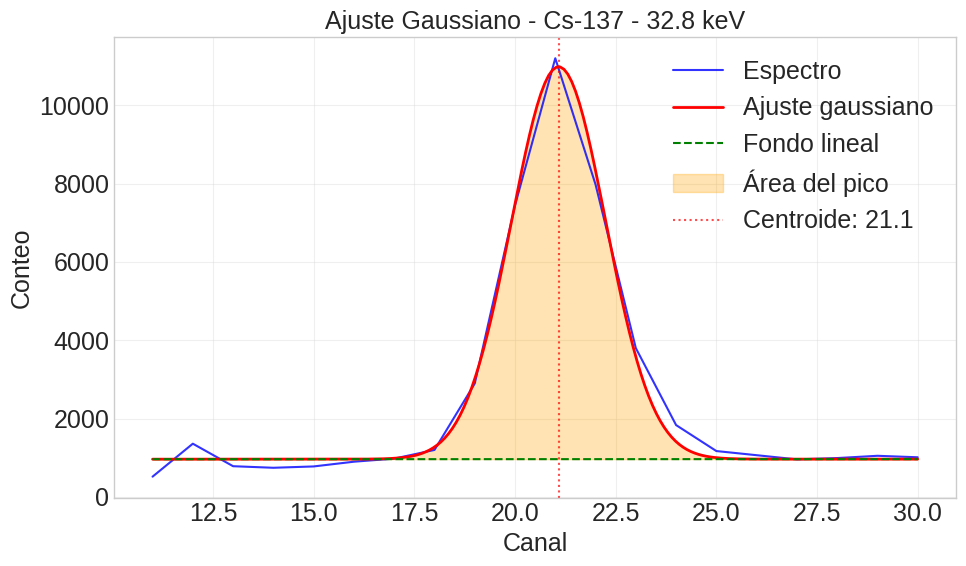

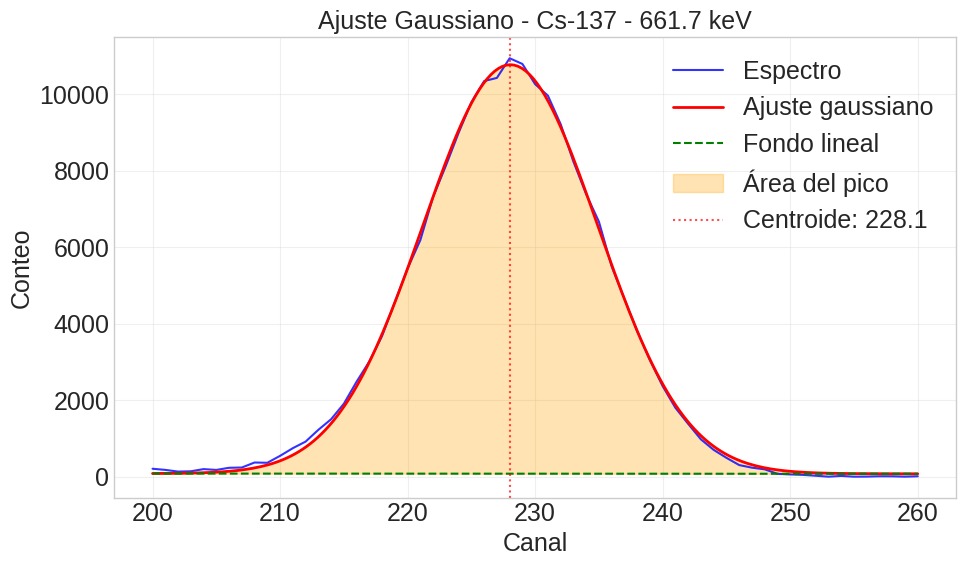


Na-22:
----------------------------------------
    Centroide: 179.47(6) canales
    FWHM: 13.5(2) canales
    Intensidad: 20250(2025) cuentas
    Centroide: 414.4(2) canales
    FWHM: 22.6(5) canales
    Intensidad: 4995(500) cuentas


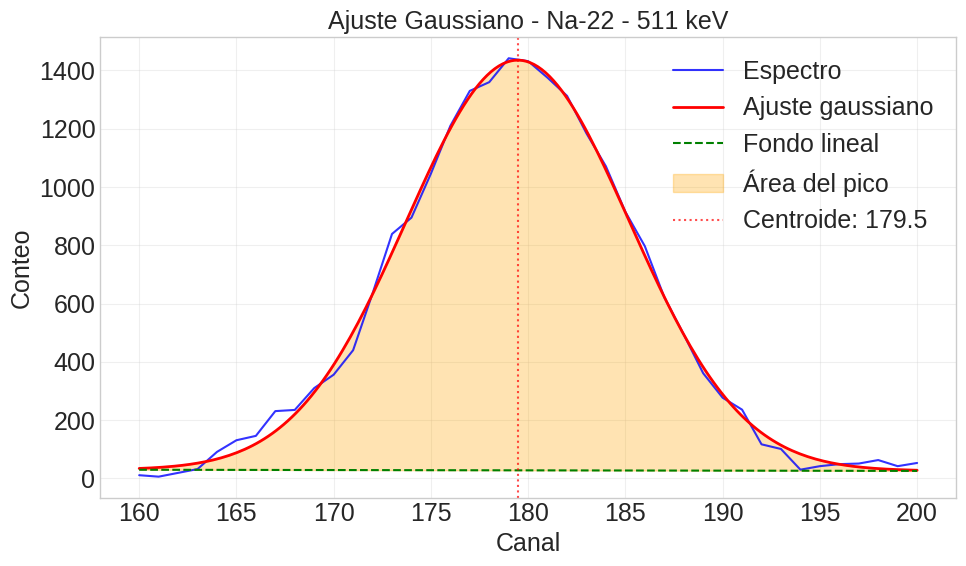

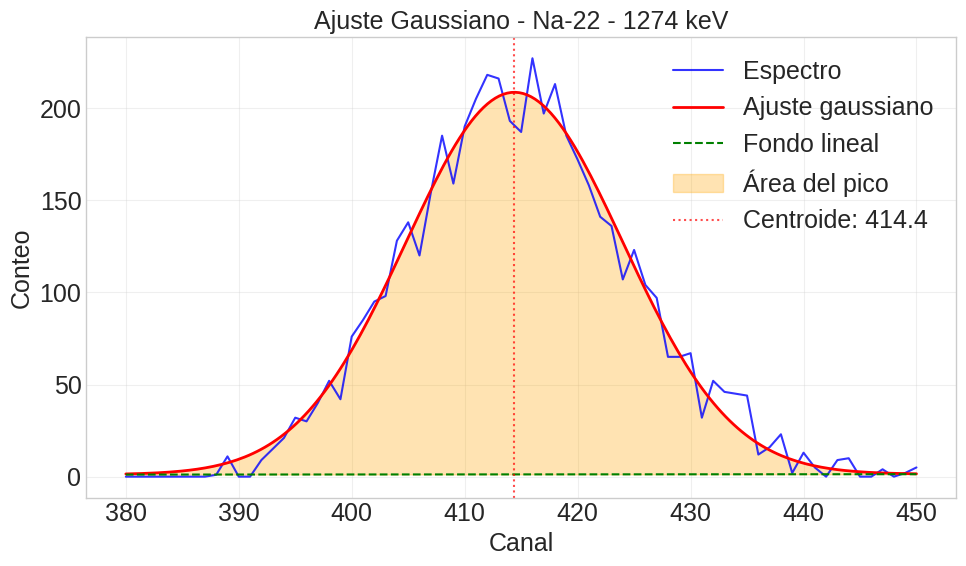

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (12, 8)

# Archivos
archivos = [
    "NaI_22Na_600s.dat", "NaI_137Cs_600s.dat",
    "NaI_Fondo_600s.dat"
]

labels = ["Na-22 (600s)", "Cs-137 (600s)",
          "Fondo (600s)"]
colores = ['red', 'blue', 'gray']

def leer_espectro(archivo):
    try:
        data = pd.read_csv(archivo, delim_whitespace=True, header=None, comment='#')

        for col in data.columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')

        data = data.dropna(how='all')

        if data.shape[1] >= 2:
            canal = data.iloc[:, 0].values
            conteo = data.iloc[:, 1].values
        else:
            canal = np.arange(len(data))
            conteo = data.iloc[:, 0].values

        return canal, conteo

    except Exception as e:
        print(f"Error leyendo {archivo}: {e}")
        return None, None

espectros = {}
for archivo, label, color in zip(archivos, labels, colores):
    canal, conteo = leer_espectro(archivo)
    if canal is not None and conteo is not None:
        espectros[archivo] = {'canal': canal, 'conteo': conteo, 'label': label}


def interpolar_espectros(canal1, conteo1, canal2, conteo2):
    canal_comun = np.arange(0, 1024)
    conteo1_interp = np.interp(canal_comun, canal1, conteo1, left=0, right=0)
    conteo2_interp = np.interp(canal_comun, canal2, conteo2, left=0, right=0)
    return canal_comun, conteo1_interp, conteo2_interp

espectros_restados = {}

# Para fuentes de 600s
fuentes_600s = ["NaI_22Na_600s.dat", "NaI_137Cs_600s.dat"]
for fuente in fuentes_600s:
    if fuente in espectros and "NaI_Fondo_600s.dat" in espectros:
        canal_comun, fuente_interp, fondo_interp = interpolar_espectros(
            espectros[fuente]['canal'], espectros[fuente]['conteo'],
            espectros["NaI_Fondo_600s.dat"]['canal'], espectros["NaI_Fondo_600s.dat"]['conteo']
        )
        resta = np.maximum(fuente_interp - fondo_interp, 0)
        nombre_resta = fuente.replace('.dat', '_resta')
        espectros_restados[nombre_resta] = {'canal': canal_comun, 'conteo': resta}


# 3 FUNCIONES PARA AJUSTES GAUSSIANOS

def gauss_bg(x, mu, sigma, A, a0, a1):
    #Gaussiana + fondo lineal
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + a0 + a1 * x


def calcular_intensidad_robusta(A, sigma, x_region, y_region, popt):
    #integra numéricamente
    try:
        # Integración numérica directa del área sobre el fondo
        mu, sigma, A_val, a0, a1 = popt

        # Crear función gaussiana pura
        def gauss_pura(x):
            return A_val * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

        # Integrar en la región del pico
        x_fine = np.linspace(x_region.min(), x_region.max(), 1000)
        gauss_values = gauss_pura(x_fine)

        # Calcular área mediante integración trap
        area = np.trapz(gauss_values, x_fine)

        # Estimación conservadora del error (10% del área)
        error_area = 0.1 * area

        return max(area, 0), error_area

    except:
        c = np.sqrt(2 * np.pi)
        area = A * sigma * c
        return max(area, 0), 0.1 * area

def calcular_fwhm_robusto(sigma, perr=None):
    fwhm = 2.355 * sigma
    if perr is not None and len(perr) > 1:
        dfwhm = 2.355 * perr[1]
    else:
        dfwhm = 0.1 * fwhm

    return max(fwhm, 0), dfwhm

def fmt_par(x, dx):
    if dx == 0 or np.isnan(dx) or x <= 0:
        return f"{max(x, 0):.1f}"
    dec = int(np.floor(np.log10(abs(dx)))) if dx != 0 else 0
    ndec = max(0, -dec)
    x_str = f"{max(x, 0):.{ndec}f}"
    dx_str = str(int(round(dx * 10**ndec)))
    return f"{x_str}({dx_str})"

# REGIONES DE AJUSTE


regiones_picos = {
    "Cs-137": [
        {"nombre": "32.8 keV", "rango": (11, 30), "color": "black"},
        {"nombre": "661.7 keV", "rango": (200, 260), "color": "red"}
    ],
    "Na-22": [
        {"nombre": "511 keV", "rango": (160, 200), "color": "blue"},
        {"nombre": "1274 keV", "rango": (380, 450), "color": "green"}
    ]
}

# Mapeo de fuentes a archivos restados
mapeo_fuentes = {
    "Cs-137": "NaI_137Cs_600s_resta",
    "Na-22": "NaI_22Na_600s_resta"
}

# AJUSTES GAUSSIANOS


resultados_ajustes = {}

for fuente, picos_info in regiones_picos.items():
    print(f"\n{fuente}:")
    print("-" * 40)

    archivo_resta = mapeo_fuentes[fuente]
    if archivo_resta not in espectros_restados:
        print(f"  No se encontró espectro restado")
        continue

    datos = espectros_restados[archivo_resta]
    x = datos['canal']
    y = datos['conteo']

    ajustes_fuente = []

    for pico_info in picos_info:
        nombre = pico_info["nombre"]
        x_min, x_max = pico_info["rango"]
        color = pico_info["color"]

        # Definir región del pico
        mask = (x >= x_min) & (x <= x_max)
        x_region = x[mask]
        y_region = y[mask]

        if len(x_region) < 5:
            print(f" Región muy pequeña para ajuste")
            continue

        idx_max = np.argmax(y_region)
        mu_guess = x_region[idx_max]
        A_guess = max(y_region.max() - np.percentile(y_region, 20), 10)  # Evitar valores negativos
        sigma_guess = 8.0
        a0_guess = np.percentile(y_region, 20)
        a1_guess = 0.0

        # Límites para evitar parámetros no físicos
        bounds = ([x_min, 1, 1, 0, -0.1], [x_max, 50, A_guess*3, A_guess, 0.1])

        p0 = [mu_guess, sigma_guess, A_guess, a0_guess, a1_guess]

        try:
            # Ajuste gaussiano con límites
            popt, pcov = curve_fit(gauss_bg, x_region, y_region, p0=p0,
                                 bounds=bounds, maxfev=5000)
            perr = np.sqrt(np.diag(pcov))

            # Calcular parámetros de forma robusta
            mu, sigma, A, a0, a1 = popt
            FWHM, dFWHM = calcular_fwhm_robusto(sigma, perr)
            I, dI = calcular_intensidad_robusta(A, sigma, x_region, y_region, popt)

            # Asegurar valores positivos
            FWHM = max(FWHM, 0)
            I = max(I, 0)

            # Guardar resultados
            info_pico = {
                'nombre': nombre,
                'mu': mu, 'dmu': perr[0],
                'sigma': sigma, 'dsigma': perr[1],
                'FWHM': FWHM, 'dFWHM': dFWHM,
                'intensidad': I, 'dintensidad': dI,
                'x_region': x_region, 'y_region': y_region,
                'x_fit': np.linspace(x_min, x_max, 200),
                'parametros': popt
            }
            ajustes_fuente.append(info_pico)

            print(f"    Centroide: {fmt_par(mu, perr[0])} canales")
            print(f"    FWHM: {fmt_par(FWHM, dFWHM)} canales")
            print(f"    Intensidad: {fmt_par(I, dI)} cuentas")

        except Exception as e:
            print(f"    Error en ajuste: {e}")

    resultados_ajustes[fuente] = ajustes_fuente

    # GRAFICAS INDIVIDUALES POR PICO - CON ESPECTRO CONTINUO
    if ajustes_fuente:
        for ajuste in ajustes_fuente:
            plt.figure(figsize=(10, 6))

            # Calcular curva ajustada
            x_fit = ajuste['x_fit']
            y_fit = gauss_bg(x_fit, *ajuste['parametros'])
            mu, sigma, A, a0, a1 = ajuste['parametros']
            fondo = a0 + a1 * x_fit

            # Graficar espectro como línea continua
            plt.plot(ajuste['x_region'], ajuste['y_region'], 'b-',
                    linewidth=1.5, label='Espectro', alpha=0.8)
            plt.plot(x_fit, y_fit, 'r-', linewidth=2, label='Ajuste gaussiano')
            plt.plot(x_fit, fondo, 'g--', linewidth=1.5, label='Fondo lineal')
            plt.fill_between(x_fit, fondo, y_fit, where=(y_fit > fondo),
                           color='orange', alpha=0.3, label='Área del pico')

            # Marcar centroide
            plt.axvline(x=mu, color='red', linestyle=':', alpha=0.7,
                       label=f'Centroide: {mu:.1f}')

            plt.xlabel("Canal", fontsize=18)
            plt.ylabel("Conteo", fontsize=18)
            plt.title(f"Ajuste Gaussiano - {fuente} - {ajuste['nombre']}", fontsize=18)
            plt.legend()
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()


#Co60 Doble Gaussiana

Resultados:
  Pico 1 (1173 keV):
    Centroide: 384.65(8) canales
    FWHM: 21.0(2) canales
    Intensidad: 28745(2874) cuentas
  Pico 2 (1332 keV):
    Centroide: 432.95(9) canales
    FWHM: 22.3(3) canales
    Intensidad: 26371(2637) cuentas
  Parámetros de fondo finales: a0=818.8, a1=-1.709


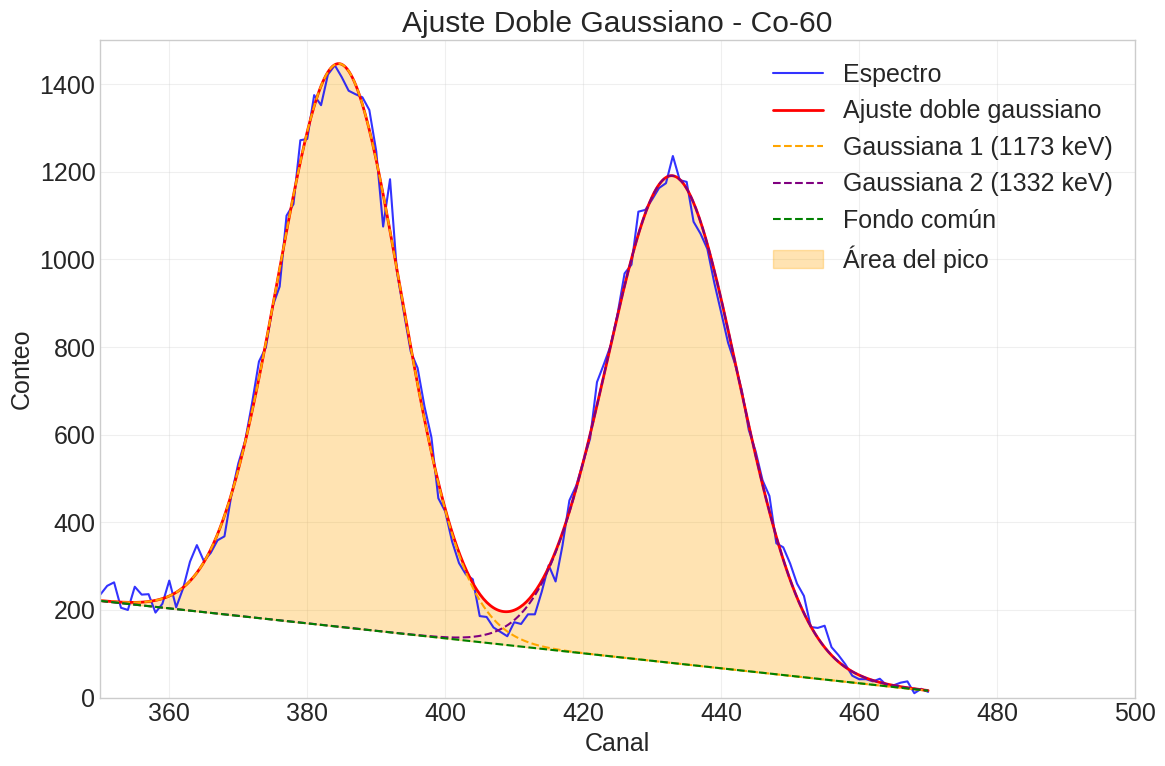

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (12, 8)

def leer_espectro(archivo):
    try:
        data = pd.read_csv(archivo, delim_whitespace=True, header=None, comment='#')

        for col in data.columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')

        data = data.dropna(how='all')

        if data.shape[1] >= 2:
            canal = data.iloc[:, 0].values
            conteo = data.iloc[:, 1].values
        else:
            canal = np.arange(len(data))
            conteo = data.iloc[:, 0].values

        return canal, conteo

    except Exception as e:
        print(f"Error leyendo {archivo}: {e}")
        return None, None

def interpolar_espectros(canal1, conteo1, canal2, conteo2):
    canal_comun = np.arange(0, 1024)
    conteo1_interp = np.interp(canal_comun, canal1, conteo1, left=0, right=0)
    conteo2_interp = np.interp(canal_comun, canal2, conteo2, left=0, right=0)
    return canal_comun, conteo1_interp, conteo2_interp

def gauss_bg(x, mu, sigma, A, a0, a1):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + a0 + a1 * x

def gauss_doble(x, mu1, sigma1, A1, mu2, sigma2, A2, a0, a1):
    g1 = A1 * np.exp(-0.5 * ((x - mu1) / sigma1) ** 2)
    g2 = A2 * np.exp(-0.5 * ((x - mu2) / sigma2) ** 2)
    return g1 + g2 + a0 + a1 * x

def calcular_intensidad_robusta(A, sigma, x_region, y_region, popt):
    try:
        mu, sigma, A_val, a0, a1 = popt

        def gauss_pura(x):
            return A_val * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

        x_fine = np.linspace(x_region.min(), x_region.max(), 1000)
        gauss_values = gauss_pura(x_fine)
        area = np.trapz(gauss_values, x_fine)
        error_area = 0.1 * area

        return max(area, 0), error_area

    except:
        c = np.sqrt(2 * np.pi)
        area = A * sigma * c
        return max(area, 0), 0.1 * area

def calcular_fwhm_robusto(sigma, perr=None):
    fwhm = 2.355 * sigma
    if perr is not None and len(perr) > 1:
        dfwhm = 2.355 * perr[1]
    else:
        dfwhm = 0.1 * fwhm

    return max(fwhm, 0), dfwhm

def fmt_par(x, dx):
    if dx == 0 or np.isnan(dx) or x <= 0:
        return f"{max(x, 0):.1f}"
    dec = int(np.floor(np.log10(abs(dx)))) if dx != 0 else 0
    ndec = max(0, -dec)
    x_str = f"{max(x, 0):.{ndec}f}"
    dx_str = str(int(round(dx * 10**ndec)))
    return f"{x_str}({dx_str})"

# ANÁLISIS ESPECÍFICO PARA COBALTO-60


# Leer datos del Cobalto-60 y fondo
archivo_co60 = "NaI_60Co_600s.dat"
archivo_fondo = "NaI_Fondo_600s.dat"

canal_co60, conteo_co60 = leer_espectro(archivo_co60)
canal_fondo, conteo_fondo = leer_espectro(archivo_fondo)

if canal_co60 is not None and canal_fondo is not None:
    # Interpolar y restar fondo
    canal_comun, co60_interp, fondo_interp = interpolar_espectros(
        canal_co60, conteo_co60, canal_fondo, conteo_fondo
    )
    espectro_co60_restado = np.maximum(co60_interp - fondo_interp, 0)


    # Definir regiones de los picos del Co-60
    regiones_co60 = [
        {"nombre": "1173 keV", "rango": (370, 400), "color": "orange"},
        {"nombre": "1332 keV", "rango": (400, 450), "color": "purple"}
    ]

    a0_min = 0
    a0_max = 1000
    a1_min = -2.0
    a1_max = 2.0


    # AJUSTES GAUSSIANOS INDIVIDUALES PARA Co-60
    resultados_co60 = []

    for pico_info in regiones_co60:
        nombre = pico_info["nombre"]
        x_min, x_max = pico_info["rango"]
        color = pico_info["color"]



        # Definir región del pico
        mask = (canal_comun >= x_min) & (canal_comun <= x_max)
        x_region = canal_comun[mask]
        y_region = espectro_co60_restado[mask]

        if len(x_region) < 5:
            print(f"  ✗ Región muy pequeña para ajuste")
            continue

        # Estimaciones iniciales
        idx_max = np.argmax(y_region)
        mu_guess = x_region[idx_max]
        A_guess = max(y_region.max() - np.percentile(y_region, 20), 10)
        sigma_guess = 8.0

        a0_guess = np.clip(np.percentile(y_region, 20), a0_min, a0_max)
        a1_guess = np.clip(0.0, a1_min, a1_max)

        bounds = ([x_min, 1, 1, a0_min, a1_min],
                 [x_max, 50, A_guess*3, a0_max, a1_max])

        p0 = [mu_guess, sigma_guess, A_guess, a0_guess, a1_guess]

        try:
            # Ajuste gaussiano con límites
            popt, pcov = curve_fit(gauss_bg, x_region, y_region, p0=p0,
                                 bounds=bounds, maxfev=5000)
            perr = np.sqrt(np.diag(pcov))

            # Calcular parámetros
            mu, sigma, A, a0, a1 = popt
            FWHM, dFWHM = calcular_fwhm_robusto(sigma, perr)
            I, dI = calcular_intensidad_robusta(A, sigma, x_region, y_region, popt)

            FWHM = max(FWHM, 0)
            I = max(I, 0)

            # Guardar resultados
            info_pico = {
                'nombre': nombre,
                'mu': mu, 'dmu': perr[0],
                'sigma': sigma, 'dsigma': perr[1],
                'FWHM': FWHM, 'dFWHM': dFWHM,
                'intensidad': I, 'dintensidad': dI,
                'x_region': x_region, 'y_region': y_region,
                'x_fit': np.linspace(x_min, x_max, 200),
                'parametros': popt
            }
            resultados_co60.append(info_pico)


            plt.show()

        except Exception as e:
            print(f"  ✗ Error en ajuste: {e}")


    if len(resultados_co60) >= 2:
        # Definir región que incluya ambos picos
        pico1 = resultados_co60[0]
        pico2 = resultados_co60[1]

        x_min = min(pico1['x_region'].min(), pico2['x_region'].min()) - 20
        x_max = max(pico1['x_region'].max(), pico2['x_region'].max()) + 20

        mask = (canal_comun >= x_min) & (canal_comun <= x_max)
        x_region = canal_comun[mask]
        y_region = espectro_co60_restado[mask]

        mu1, sigma1, A1, a01, a11 = pico1['parametros']
        mu2, sigma2, A2, a02, a12 = pico2['parametros']

        # FRONTERAS MANUALES
        a0_guess = np.clip((a01 + a02) / 2, a0_min, a0_max)
        a1_guess = np.clip((a11 + a12) / 2, a1_min, a1_max)

        p0_doble = [mu1, sigma1, A1, mu2, sigma2, A2, a0_guess, a1_guess]

        bounds_doble = ([x_min, 1, 1, x_min+50, 1, 1, a0_min, a1_min],
                       [x_max, 50, A1*3, x_max, 50, A2*3, a0_max, a1_max])


        try:
            # Ajuste doble gaussiano
            popt_doble, pcov_doble = curve_fit(gauss_doble, x_region, y_region,
                                             p0=p0_doble, bounds=bounds_doble, maxfev=10000)
            perr_doble = np.sqrt(np.diag(pcov_doble))

            mu1, sigma1, A1, mu2, sigma2, A2, a0, a1 = popt_doble

            # Calcular parámetros
            FWHM1, dFWHM1 = calcular_fwhm_robusto(sigma1, perr_doble[:3])
            FWHM2, dFWHM2 = calcular_fwhm_robusto(sigma2, perr_doble[3:6])
            I1, dI1 = calcular_intensidad_robusta(A1, sigma1, x_region, y_region, popt_doble[:5])
            I2, dI2 = calcular_intensidad_robusta(A2, sigma2, x_region, y_region, [mu2, sigma2, A2, a0, a1])

            print("Resultados:")
            print(f"  Pico 1 (1173 keV):")
            print(f"    Centroide: {fmt_par(mu1, perr_doble[0])} canales")
            print(f"    FWHM: {fmt_par(FWHM1, dFWHM1)} canales")
            print(f"    Intensidad: {fmt_par(I1, dI1)} cuentas")

            print(f"  Pico 2 (1332 keV):")
            print(f"    Centroide: {fmt_par(mu2, perr_doble[3])} canales")
            print(f"    FWHM: {fmt_par(FWHM2, dFWHM2)} canales")
            print(f"    Intensidad: {fmt_par(I2, dI2)} cuentas")

            print(f"  Parámetros de fondo finales: a0={a0:.1f}, a1={a1:.3f}")

            # Graficar ajuste doble
            plt.figure(figsize=(12, 8))
            x_fit = np.linspace(x_min, x_max, 500)
            y_fit = gauss_doble(x_fit, *popt_doble)

            # Componentes individuales
            g1 = A1 * np.exp(-0.5 * ((x_fit - mu1) / sigma1) ** 2)
            g2 = A2 * np.exp(-0.5 * ((x_fit - mu2) / sigma2) ** 2)
            fondo = a0 + a1 * x_fit

            plt.plot(x_region, y_region, 'b-', linewidth=1.5, label='Espectro', alpha=0.8)
            plt.plot(x_fit, y_fit, 'r-', linewidth=2, label='Ajuste doble gaussiano')
            plt.plot(x_fit, g1 + fondo, 'orange', linestyle='--', linewidth=1.5, label='Gaussiana 1 (1173 keV)')
            plt.plot(x_fit, g2 + fondo, 'purple', linestyle='--', linewidth=1.5, label='Gaussiana 2 (1332 keV)')
            plt.plot(x_fit, fondo, 'g--', linewidth=1.5, label='Fondo común')
            plt.fill_between(x_fit, fondo, y_fit, where=(y_fit > fondo),
                           color='orange', alpha=0.3, label='Área del pico')
            plt.xlabel("Canal")
            plt.xlim(350, 500)
            plt.ylim(0, 1500)
            plt.ylabel("Conteo")
            plt.title("Ajuste Doble Gaussiano - Co-60")
            plt.legend()
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error en ajuste doble: {e}")


#Co57 Doble Gaussiana

  Pico 122.1 keV:
    Centroide: 57.0 ± 15.3 canales
    FWHM: 18.8 ± 65.4 canales
    Intensidad: 16366 cuentas
  Pico 136.5 keV:
    Centroide: 58.8 ± 0.1 canales
    FWHM: 6.1 ± 0.4 canales
    Intensidad: 26729 cuentas
  Fondo lineal: a0 = 252.2, a1 = -5.000 (pendiente)


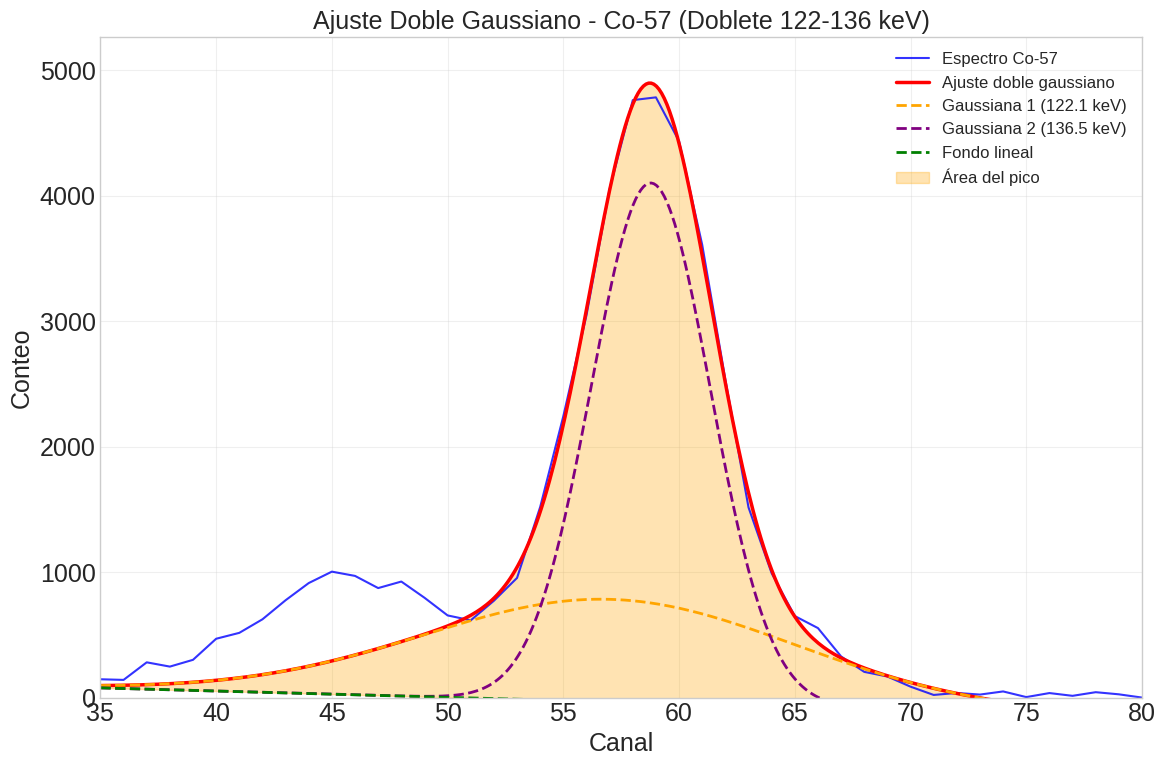

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (12, 8)


def leer_espectro(archivo):
    try:
        data = pd.read_csv(archivo, delim_whitespace=True, header=None, comment='#')

        # Convertir a numérico
        for col in data.columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')

        data = data.dropna(how='all')

        if data.shape[1] >= 2:
            canal = data.iloc[:, 0].values
            conteo = data.iloc[:, 1].values
        else:
            canal = np.arange(len(data))
            conteo = data.iloc[:, 0].values

        return canal, conteo

    except Exception as e:
        print(f"Error leyendo {archivo}: {e}")
        return None, None

def interpolar_espectros(canal1, conteo1, canal2, conteo2):
    canal_comun = np.arange(0, 1024)
    conteo1_interp = np.interp(canal_comun, canal1, conteo1, left=0, right=0)
    conteo2_interp = np.interp(canal_comun, canal2, conteo2, left=0, right=0)
    return canal_comun, conteo1_interp, conteo2_interp

# Leer archivos de Co-57
canal_57Co, conteo_57Co = leer_espectro("NaI_57Co_300s.dat")
canal_fondo, conteo_fondo = leer_espectro("NaI_Fondo_300s.dat")

if canal_57Co is not None and conteo_57Co is not None and canal_fondo is not None and conteo_fondo is not None:
    # Restar fondo
    canal_comun, co57_interp, fondo_interp = interpolar_espectros(
        canal_57Co, conteo_57Co, canal_fondo, conteo_fondo
    )
    resta_57Co = np.maximum(co57_interp - fondo_interp, 0)

else:
    print("Error: No se pudieron leer los archivos de Co-57")
    exit()

def gauss_doble(x, mu1, sigma1, A1, mu2, sigma2, A2, a0, a1):
    g1 = A1 * np.exp(-0.5 * ((x - mu1) / sigma1) ** 2)
    g2 = A2 * np.exp(-0.5 * ((x - mu2) / sigma2) ** 2)
    fondo = a0 + a1 * x
    return g1 + g2 + fondo

def calcular_intensidad(A, sigma):
    return A * sigma * np.sqrt(2 * np.pi)

def calcular_fwhm(sigma):
    return 2.355 * sigma


mu_guess_122 = 58.0
mu_guess_136 = 59.0

x_min, x_max = 50, 70
mask = (canal_comun >= x_min) & (canal_comun <= x_max)
x_region = canal_comun[mask]
y_region = resta_57Co[mask]

canal_inicio_fondo = 45



puntos_fondo = x_region >= canal_inicio_fondo
x_fondo = x_region[puntos_fondo]
y_fondo = y_region[puntos_fondo]

if len(x_fondo) >= 10:
    y_left = np.mean(y_fondo[:5])
    y_right = np.mean(y_fondo[-5:])
    a1_guess = (y_right - y_left) / (x_fondo[-1] - x_fondo[0])
else:
    # Fallback: usar toda la región
    y_left = np.mean(y_region[:5])
    y_right = np.mean(y_region[-5:])
    a1_guess = (y_right - y_left) / (x_region[-1] - x_region[0])


a1_guess = np.clip(a1_guess, -2.0, 2.0)
a0_guess = y_left - a1_guess * x_region[0]


sigma_guess = 3.0
A_guess_122 = np.max(y_region) * 0.6  # Amplitud estimada del pico 122 keV
A_guess_136 = np.max(y_region) * 0.4  # Amplitud estimada del pico 136 keV

p0_doble = [mu_guess_122, sigma_guess, A_guess_122, mu_guess_136, sigma_guess, A_guess_136, a0_guess, a1_guess]

bounds_doble = ([x_min, 1.0, 100, x_min+1, 1.0, 100, 0, -5.0],
                [x_max, 8.0, A_guess_122*10, x_max, 8.0, A_guess_136*10, max(y_region)*3, 5.0])

try:
    for i, (p0_val, bound_low, bound_high) in enumerate(zip(p0_doble, bounds_doble[0], bounds_doble[1])):
        if not (bound_low <= p0_val <= bound_high):
            print(f"Advertencia: p0[{i}] = {p0_val} fuera de límites [{bound_low}, {bound_high}]")

    # Ajuste doble gaussiano
    popt_doble, pcov_doble = curve_fit(gauss_doble, x_region, y_region, p0=p0_doble,
                                     bounds=bounds_doble, maxfev=10000)
    perr_doble = np.sqrt(np.diag(pcov_doble))

    mu_122, sigma_122, A_122, mu_136, sigma_136, A_136, a0, a1 = popt_doble

    # Calcular parámetros para cada pico del doblete
    FWHM_122 = calcular_fwhm(sigma_122)
    FWHM_136 = calcular_fwhm(sigma_136)
    I_122 = calcular_intensidad(A_122, sigma_122)
    I_136 = calcular_intensidad(A_136, sigma_136)

    # Calcular centroide ponderado del doblete
    centroide_ponderado = (I_122 * mu_122 + I_136 * mu_136) / (I_122 + I_136)

    print(f"  Pico 122.1 keV:")
    print(f"    Centroide: {mu_122:.1f} ± {perr_doble[0]:.1f} canales")
    print(f"    FWHM: {FWHM_122:.1f} ± {2.355*perr_doble[1]:.1f} canales")
    print(f"    Intensidad: {I_122:.0f} cuentas")

    print(f"  Pico 136.5 keV:")
    print(f"    Centroide: {mu_136:.1f} ± {perr_doble[3]:.1f} canales")
    print(f"    FWHM: {FWHM_136:.1f} ± {2.355*perr_doble[4]:.1f} canales")
    print(f"    Intensidad: {I_136:.0f} cuentas")

    print(f"  Fondo lineal: a0 = {a0:.1f}, a1 = {a1:.3f} (pendiente)")

except Exception as e:
    print(f" Error en ajuste doble: {e}")

    p0_conservador = [mu_guess_122, 2.5, A_guess_122*0.5, mu_guess_136, 2.5, A_guess_136*0.5,
                      np.mean(y_region), 0.0]  # Pendiente 0 inicialmente

    try:
        popt_doble, pcov_doble = curve_fit(gauss_doble, x_region, y_region, p0=p0_conservador,
                                         bounds=bounds_doble, maxfev=10000)
        perr_doble = np.sqrt(np.diag(pcov_doble))

        mu_122, sigma_122, A_122, mu_136, sigma_136, A_136, a0, a1 = popt_doble

        # Calcular parámetros para cada pico del doblete
        FWHM_122 = calcular_fwhm(sigma_122)
        FWHM_136 = calcular_fwhm(sigma_136)
        I_122 = calcular_intensidad(A_122, sigma_122)
        I_136 = calcular_intensidad(A_136, sigma_136)

        # Calcular centroide ponderado del doblete
        centroide_ponderado = (I_122 * mu_122 + I_136 * mu_136) / (I_122 + I_136)

    except Exception as e2:
        exit()


plt.figure(figsize=(12, 8))

# región ampliada para visualización
x_min_viz = 35
x_max_viz = 80

# Crear máscara para la región de visualización ampliada
mask_viz = (canal_comun >= x_min_viz) & (canal_comun <= x_max_viz)
x_viz = canal_comun[mask_viz]
y_viz = resta_57Co[mask_viz]

# Graficar el espectro completo en la región ampliada
plt.plot(x_viz, y_viz, 'b-', linewidth=1.5, label='Espectro Co-57', alpha=0.8)


# Extender el ajuste para mostrar gaussianas completas
x_fit_extended = np.linspace(x_min_viz, x_max_viz, 400)
y_fit_extended = gauss_doble(x_fit_extended, *popt_doble)
plt.plot(x_fit_extended, y_fit_extended, 'r-', linewidth=2.5, label='Ajuste doble gaussiano')

# Graficar componentes individuales del doblete
g1_extended = A_122 * np.exp(-0.5 * ((x_fit_extended - mu_122) / sigma_122) ** 2)
g2_extended = A_136 * np.exp(-0.5 * ((x_fit_extended - mu_136) / sigma_136) ** 2)
fondo_extended = a0 + a1 * x_fit_extended

plt.plot(x_fit_extended, g1_extended + fondo_extended, 'orange', linestyle='--',
         linewidth=2, label='Gaussiana 1 (122.1 keV)')
plt.plot(x_fit_extended, g2_extended + fondo_extended, 'purple', linestyle='--',
         linewidth=2, label='Gaussiana 2 (136.5 keV)')
plt.plot(x_fit_extended, fondo_extended, 'g--', linewidth=2, label=f'Fondo lineal')

# Rellenar área bajo las gaussianas
umbral = 0.001
max_g1 = np.max(g1_extended)
max_g2 = np.max(g2_extended)

mask_g1_sig = g1_extended > umbral * max_g1
mask_g2_sig = g2_extended > umbral * max_g2
mask_gaussianas_sig = mask_g1_sig | mask_g2_sig

x_gaussianas = x_fit_extended[mask_gaussianas_sig]
y_fit_gaussianas = y_fit_extended[mask_gaussianas_sig]
fondo_gaussianas = fondo_extended[mask_gaussianas_sig]

plt.fill_between(x_gaussianas, fondo_gaussianas, y_fit_gaussianas,
                where=(y_fit_gaussianas > fondo_gaussianas),
                color='orange', alpha=0.3, label='Área del pico')


plt.xlabel("Canal", fontsize=18)
plt.ylabel("Conteo", fontsize=18)
plt.title("Ajuste Doble Gaussiano - Co-57 (Doblete 122-136 keV)", fontsize=18)
plt.legend(fontsize=12, loc='upper right')
plt.grid(alpha=0.3)
plt.xlim(x_min_viz, x_max_viz)
plt.ylim(0, max(y_viz) * 1.1)

plt.tight_layout()
plt.show()


#Calibración

CALIBRACIÓN ENERGÍA-CANAL
Ecuación: E(keV) = (-53.1841 ± 6.7541) + (3.1909 ± 0.0247) × canal
R² = 0.999641

TABLA 2.2 - CALIDAD DE LA CALIBRACIÓN EN ENERGÍA
Canal      E_prop (keV) E_ajust (keV)    ΔE (keV)     %        FWHM (keV)  
----------------------------------------------------------------------------------------------------
21.08(0.03) 32.8         14.08(6.77) -18.72       -57.07   8.78(0.22)
228.05(0.03) 661.7        674.51(8.80) 12.81        1.94     51.21(0.29)
179.48(0.11) 511.0        519.52(8.09) 8.52         1.67     43.33(1.18)
414.36(0.52) 1274.5       1269.01(12.37) -5.49        -0.43    71.48(5.74)
384.39(0.20) 1173.2       1173.38(11.67) 0.18         0.02     67.14(1.63)
432.58(0.24) 1332.5       1327.15(12.66) -5.35        -0.40    64.46(2.01)
58.00(2.00) 122.1        131.89(9.40) 9.79         8.02     31.91(22.34)
58.90(2.00) 136.5        134.76(9.41) -1.74        -1.27    15.95(3.19)


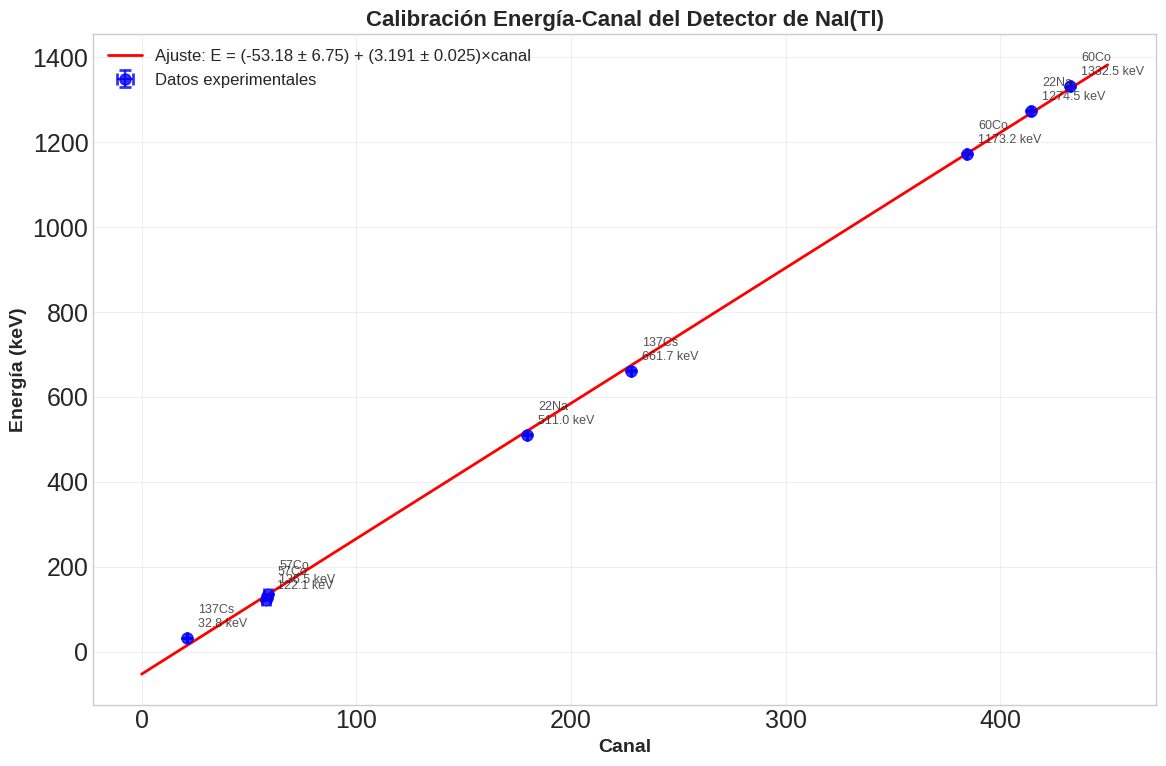

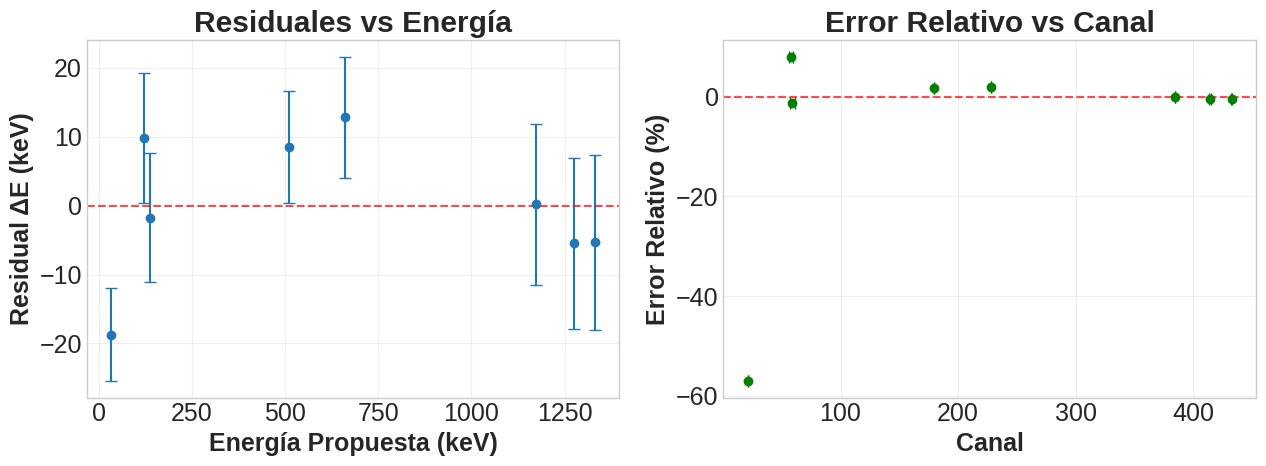


ANÁLISIS ESTADÍSTICO DEL AJUSTE
Error cuadrático medio: 9.6487 keV
Error absoluto medio: 7.8248 keV
Error relativo medio: 8.85 %
Máximo error absoluto: 18.7193 keV
Máximo error relativo: 57.07 %

Resolución del detector (FWHM/E):
  Mejor: 4.84% a 1332.5 keV
  Peor: 26.75% a 32.8 keV
  Promedio: 12.12%

TABLA 2.2 EN FORMATO LaTeX
\begin{table}[h]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
canal & $E_\gamma$ (keV) & $E_\gamma$ (keV) & $\Delta E$ (keV) & \% & FWHM (keV) \\
(experimental) & (propuesta) & (ec. 2.1) & & & \\
\hline
21.08(0.03) & 32.8^{a} & 14.08(6.77) & -18.72 & -57.07 & 8.78(0.22) \\
228.05(0.03) & 661.7 & 674.51(8.80) & 12.81 & 1.94 & 51.21(0.29) \\
179.48(0.11) & 511.0 & 519.52(8.09) & 8.52 & 1.67 & 43.33(1.18) \\
414.36(0.52) & 1274.5 & 1269.01(12.37) & -5.49 & -0.43 & 71.48(5.74) \\
384.39(0.20) & 1173.2 & 1173.38(11.67) & 0.18 & 0.02 & 67.14(1.63) \\
432.58(0.24) & 1332.5 & 1327.15(12.66) & -5.35 & -0.40 & 64.46(2.01) \\
58.00(2.00) & 122.1 & 131.89(9.40) & 9.79

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy import stats

# DATOS EXPERIMENTALES REALES DE TU TABLA
datos_calibracion = {
    'fuente': ['137Cs', '137Cs', '22Na', '22Na', '60Co', '60Co', '57Co', '57Co'],
    'E_propuesta': [32.8, 661.7, 511.0, 1274.5, 1173.2, 1332.5, 122.1, 136.5],
    'canal_exp': [21.08, 228.05, 179.48, 414.36, 384.39, 432.58, 58.00, 58.90],
    'incert_canal': [0.03, 0.03, 0.11, 0.52, 0.20, 0.24, 2.00, 2.00],
    'sigma_canales': [1.17, 6.82, 5.77, 9.50, 8.93, 8.58, 4.00, 2.30],
    'incert_sigma': [0.03, 0.04, 0.16, 0.77, 0.22, 0.27, 3.00, 4.00],
    'FWHM_canales': [2.75, 16.05, 13.58, 22.40, 21.04, 20.20, 10.00, 5.00],
    'incert_FWHM': [0.07, 0.09, 0.37, 1.80, 0.51, 0.63, 7.00, 1.00]
}

df = pd.DataFrame(datos_calibracion)

# AJUSTE LINEAL: E = a + b * canal
X = df['canal_exp'].values.reshape(-1, 1)
y = df['E_propuesta'].values

modelo = LinearRegression()
modelo.fit(X, y)

# Parámetros del ajuste
a = modelo.intercept_
b = modelo.coef_[0]

# Calcular R² y errores estándar
y_pred = modelo.predict(X)
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

# Calcular errores estándar de los parámetros
n = len(X)
x_mean = np.mean(X)
s_xx = np.sum((X - x_mean) ** 2)
s_e = np.sqrt(ss_res / (n - 2))

error_b = s_e / np.sqrt(s_xx)
error_a = s_e * np.sqrt(1/n + x_mean**2/s_xx)

print("="*70)
print("CALIBRACIÓN ENERGÍA-CANAL")
print("="*70)
print(f"Ecuación: E(keV) = ({a:.4f} ± {error_a:.4f}) + ({b:.4f} ± {error_b:.4f}) × canal")
print(f"R² = {r_squared:.6f}")

# Calcular valores ajustados y errores
df['E_ajustada'] = modelo.predict(X)
df['Delta_E'] = df['E_ajustada'] - df['E_propuesta']
df['Delta_E_porcentaje'] = (df['Delta_E'] / df['E_propuesta']) * 100

# Convertir FWHM de canales a keV usando la pendiente de calibración
df['FWHM_keV'] = df['FWHM_canales'] * b
df['incert_FWHM_keV'] = df['incert_FWHM'] * b

# Calcular incertidumbres en E_ajustada (propagación de error)
df['incert_E_ajustada'] = np.sqrt(df['incert_canal']**2 * b**2 + error_a**2 + (df['canal_exp'] * error_b)**2)

# COMPLETAR TABLA 2.2
print("\n" + "="*100)
print("TABLA 2.2 - CALIDAD DE LA CALIBRACIÓN EN ENERGÍA")
print("="*100)
print(f"{'Canal':<10} {'E_prop (keV)':<12} {'E_ajust (keV)':<16} {'ΔE (keV)':<12} {'%':<8} {'FWHM (keV)':<12}")
print("-"*100)

for idx, row in df.iterrows():
    print(f"{row['canal_exp']:.2f}({row['incert_canal']:.2f}) {row['E_propuesta']:<12.1f} "
          f"{row['E_ajustada']:.2f}({row['incert_E_ajustada']:.2f}) {row['Delta_E']:<12.2f} "
          f"{row['Delta_E_porcentaje']:<8.2f} {row['FWHM_keV']:.2f}({row['incert_FWHM_keV']:.2f})")

# GRÁFICA DE CALIBRACIÓN
plt.figure(figsize=(12, 8))

# Puntos experimentales con barras de error
plt.errorbar(df['canal_exp'], df['E_propuesta'],
             xerr=df['incert_canal'], yerr=df['E_propuesta'] * 0.001,  # pequeño error en energía
             fmt='o', markersize=8, capsize=4, capthick=2,
             color='blue', alpha=0.8, label='Datos experimentales')

# Línea de ajuste
canales_continuo = np.linspace(0, 450, 100)
E_continuo = a + b * canales_continuo
plt.plot(canales_continuo, E_continuo, 'r-', linewidth=2,
         label=f'Ajuste: E = ({a:.2f} ± {error_a:.2f}) + ({b:.3f} ± {error_b:.3f})×canal')

# Configuración de la gráfica
plt.xlabel('Canal', fontsize=14, fontweight='bold')
plt.ylabel('Energía (keV)', fontsize=14, fontweight='bold')
plt.title('Calibración Energía-Canal del Detector de NaI(Tl)', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Añadir anotaciones
for idx, row in df.iterrows():
    plt.annotate(f"{row['fuente']}\n{row['E_propuesta']} keV",
                (row['canal_exp'], row['E_propuesta']),
                textcoords="offset points",
                xytext=(8,8),
                ha='left', fontsize=9, alpha=0.8)

plt.tight_layout()
plt.show()



# Ajuste FWHM-E

AJUSTE FWHM vs √E
Datos convertidos:
E =   32.8 keV → √E =  5.73 ± 0.04 keV¹/²
FWHM =  8.45 ± 0.22 keV
E =  661.7 keV → √E = 25.72 ± 0.01 keV¹/²
FWHM = 49.29 ± 0.29 keV
E = 1173.2 keV → √E = 34.25 ± 0.01 keV¹/²
FWHM = 64.61 ± 1.57 keV
E = 1332.5 keV → √E = 36.50 ± 0.01 keV¹/²
FWHM = 62.03 ± 1.94 keV
E =  511.0 keV → √E = 22.61 ± 0.01 keV¹/²
FWHM = 41.70 ± 1.14 keV
E = 1274.5 keV → √E = 35.70 ± 0.01 keV¹/²
FWHM = 68.79 ± 5.53 keV
E =  122.1 keV → √E = 11.05 ± 0.02 keV¹/²
FWHM = 30.71 ± 21.50 keV
E =  136.5 keV → √E = 11.68 ± 0.02 keV¹/²
FWHM = 15.36 ± 3.07 keV

RESULTADO DEL AJUSTE:
FWHM = (-3.07 ± 0.28) + (2.02 ± 0.02) × √E
R² = 0.9354


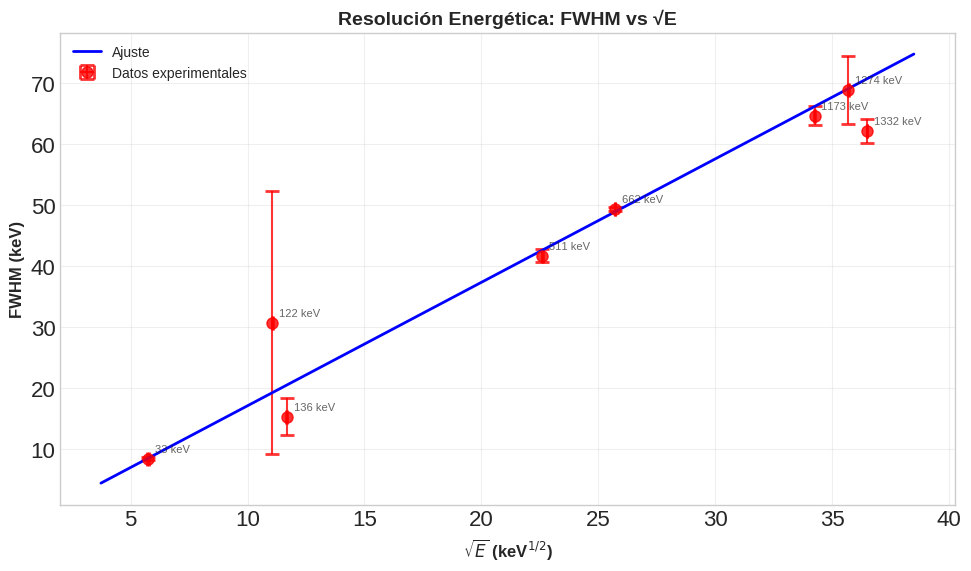


ECUACIÓN PARA EL REPORTE
\[ \text{FWHM}(E) = c_0 + c_1 \sqrt{E} \]
\[ c_0 = (-3.07 \pm 0.28) \ \text{keV} \]
\[ c_1 = (2.02 \pm 0.02) \ \text{keV}^{1/2} \]
\[ R^2 = 0.9354 \]

PREDICCIONES:
Energía (keV) FWHM predicho (keV) 
-----------------------------------
100          17.12               +/-0.33                
500          42.1                +/-0.5                 
1000         60.8                +/-0.6                 
1500         75.1                +/-0.7                 

Pendiente de calibración usada: 3.071 keV/canal


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from uncertainties import ufloat
import pandas as pd

# =============================================================================
# DATOS EXPERIMENTALES
# =============================================================================

# Datos: [Energía (keV), FWHM (canales), incertidumbre FWHM (canales)]
datos_fwhm = [
    [32.8, 2.75, 0.07],    # Cs-137 - 32.8 keV
    [661.7, 16.05, 0.09],  # Cs-137 - 662 keV
    [1173.2, 21.04, 0.51], # Co-60 - 1173 keV
    [1332.5, 20.20, 0.63], # Co-60 - 1332 keV
    [511.0, 13.58, 0.37],  # Na-22 - 511 keV
    [1274.5, 22.40, 1.80], # Na-22 - 1274 keV
    [122.1, 10.00, 7.00],  # Co-57 - 122 keV
    [136.5, 5.00, 1.00]    # Co-57 - 136 keV
]

# Pendiente de calibración energía-canal (de tu ajuste anterior)
# REEMPLAZA ESTE VALOR CON EL QUE OBTUVISTE
b_calibracion = 3.071  # keV/canal (ejemplo - usa tu valor real)
error_b_calibracion = 0.005  # Error de la pendiente (usa tu valor real)

print("="*60)
print("AJUSTE FWHM vs √E")
print("="*60)

# Preparar datos
E_keV = np.array([dato[0] for dato in datos_fwhm])
FWHM_canales = np.array([dato[1] for dato in datos_fwhm])
FWHM_canales_err = np.array([dato[2] for dato in datos_fwhm])

# Convertir FWHM de canales a keV con propagación de errores
FWHM_keV = FWHM_canales * b_calibracion
FWHM_keV_err = np.sqrt((FWHM_canales_err * b_calibracion)**2 +
                       (FWHM_canales * error_b_calibracion)**2)

# Calcular √E con propagación de errores
sqrtE = np.sqrt(E_keV)
# Error en √E: d(√E)/dE = 1/(2√E), asumiendo error de 0.5 keV en E
E_keV_err = 0.5  # Incertidumbre típica en energía
sqrtE_err = (0.5 * E_keV_err) / np.sqrt(E_keV)

print("Datos convertidos:")
for i in range(len(E_keV)):
    print(f"E = {E_keV[i]:6.1f} keV → √E = {sqrtE[i]:5.2f} ± {sqrtE_err[i]:.2f} keV¹/²")
    print(f"FWHM = {FWHM_keV[i]:5.2f} ± {FWHM_keV_err[i]:.2f} keV")

# =============================================================================
# AJUSTE LINEAL PONDERADO
# =============================================================================

def weighted_linear_fit(x, y, y_err):
    """Ajuste lineal ponderado por incertidumbres en Y"""
    weights = 1.0 / (y_err ** 2)

    sum_w = np.sum(weights)
    sum_wx = np.sum(weights * x)
    sum_wy = np.sum(weights * y)
    sum_wx2 = np.sum(weights * x ** 2)
    sum_wxy = np.sum(weights * x * y)

    delta = sum_w * sum_wx2 - sum_wx ** 2

    slope = (sum_w * sum_wxy - sum_wx * sum_wy) / delta
    intercept = (sum_wx2 * sum_wy - sum_wx * sum_wxy) / delta

    # Errores en parámetros
    slope_err = np.sqrt(sum_w / delta)
    intercept_err = np.sqrt(sum_wx2 / delta)

    return slope, intercept, slope_err, intercept_err

# Aplicar ajuste ponderado
c1, c0, c1_err, c0_err = weighted_linear_fit(sqrtE, FWHM_keV, FWHM_keV_err)

# Calcular R²
y_pred = c0 + c1 * sqrtE
ss_res = np.sum((FWHM_keV - y_pred) ** 2)
ss_tot = np.sum((FWHM_keV - np.mean(FWHM_keV)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

print(f"\nRESULTADO DEL AJUSTE:")
print(f"FWHM = ({c0:.2f} ± {c0_err:.2f}) + ({c1:.2f} ± {c1_err:.2f}) × √E")
print(f"R² = {r_squared:.4f}")

# =============================================================================
# GRÁFICA PRINCIPAL
# =============================================================================

plt.figure(figsize=(10, 6))

# Puntos experimentales con barras de error
plt.errorbar(sqrtE, FWHM_keV,
             xerr=sqrtE_err, yerr=FWHM_keV_err,
             fmt='o', markersize=8, capsize=5, capthick=2,
             color='red', alpha=0.8, label='Datos experimentales')

# Curva de ajuste
x_fit = np.linspace(min(sqrtE) - 2, max(sqrtE) + 2, 200)
y_fit = c0 + c1 * x_fit

# Banda de incertidumbre del ajuste
y_fit_upper = (c0 + c0_err) + (c1 + c1_err) * x_fit
y_fit_lower = (c0 - c0_err) + (c1 - c1_err) * x_fit

plt.plot(x_fit, y_fit, 'b-', linewidth=2,
         label='Ajuste')

#plt.fill_between(x_fit, y_fit_lower, y_fit_upper, color='blue', alpha=0.2, label='Incertidumbre del ajuste')

plt.xlabel(r'$\sqrt{E}$ (keV$^{1/2}$)', fontsize=12, fontweight='bold')
plt.ylabel('FWHM (keV)', fontsize=12, fontweight='bold')
plt.title('Resolución Energética: FWHM vs √E', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Añadir etiquetas de energías
for i, (E_val, sqrtE_val, FWHM_val) in enumerate(zip(E_keV, sqrtE, FWHM_keV)):
    plt.annotate(f'{E_val:.0f} keV',
                xy=(sqrtE_val, FWHM_val),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()

# =============================================================================
# ECUACIÓN EN FORMATO LaTeX
# =============================================================================

print("\n" + "="*60)
print("ECUACIÓN PARA EL REPORTE")
print("="*60)
print("\\[ \\text{FWHM}(E) = c_0 + c_1 \\sqrt{E} \\]")
print(f"\\[ c_0 = ({c0:.2f} \\pm {c0_err:.2f}) \\ \\text{{keV}} \\]")
print(f"\\[ c_1 = ({c1:.2f} \\pm {c1_err:.2f}) \\ \\text{{keV}}^{{1/2}} \\]")
print(f"\\[ R^2 = {r_squared:.4f} \\]")

# =============================================================================
# FUNCIÓN DE PREDICCIÓN
# =============================================================================

def predecir_fwhm(energia_keV):
    """Predice FWHM para una energía dada con incertidumbre"""
    sqrtE_val = np.sqrt(energia_keV)
    fwhm_nom = c0 + c1 * sqrtE_val
    # Propagación de error: σ_fwhm = √(σ_c0² + (√E × σ_c1)²)
    fwhm_err = np.sqrt(c0_err**2 + (sqrtE_val * c1_err)**2)
    return ufloat(fwhm_nom, fwhm_err)

# Ejemplos de predicción
print(f"\nPREDICCIONES:")
print(f"{'Energía (keV)':<12} {'FWHM predicho (keV)':<20}")
print("-" * 35)

energias_ejemplo = [100, 500, 1000, 1500]
for E in energias_ejemplo:
    FWHM_pred = predecir_fwhm(E)
    print(f"{E:<12} {FWHM_pred:<20}")

print(f"\nPendiente de calibración usada: {b_calibracion:.3f} keV/canal")

# Ajuste del 57Co


In [ ]:
from google.colab import files
import os

# Sube los archivos .dat desde tu computador
uploaded = files.upload()

# Verifica qué nombres exactos tienen los archivos subidos
print("\nArchivos disponibles en el entorno:")
for f in os.listdir():
    print(f)


Saving NaI_57Co_300s.dat to NaI_57Co_300s (1).dat
Saving NaI_Fondo_300s.dat to NaI_Fondo_300s (1).dat

Archivos disponibles en el entorno:
.config
NaI_57Co_300s.dat
NaI_57Co_300s (1).dat
NaI_Fondo_300s (1).dat
NaI_Fondo_300s.dat
sample_data


In [ ]:
import os

# Eliminamos duplicados y dejamos solo los nombres que el programa espera
if os.path.exists("NaI_57Co_300s (1).dat"):
    os.rename("NaI_57Co_300s (1).dat", "NaI_57Co_300s.dat")

if os.path.exists("NaI_Fondo_300s (1).dat"):
    os.rename("NaI_Fondo_300s (1).dat", "NaI_Fondo_300s.dat")

print("✅ Archivos listos:")
print(os.listdir())


✅ Archivos listos:
['.config', 'sample_data']


Detección automatica

Parámetros ajustados (val ± err):
  A1 =    845.188 ±  39.937
 mu1 =    102.311 ±   0.347
  s1 =     13.012 ±   0.415
  A2 =    266.107 ± 14281364.888
 mu2 =    110.324 ± 5078.194
  s2 =      0.835 ± 12658.975
  A3 =   4722.961 ±  70.000
 mu3 =    142.711 ±   0.100
  s3 =      9.069 ±   0.147
   m =     -0.337 ±   0.928
   b =    150.369 ±  59.047

Picos (mu, FWHM, area):
p1: mu=102.31 keV, FWHM= 30.64 keV, Area= 27566.8
p2: mu=110.32 keV, FWHM=  1.97 keV, Area=   557.0
p3: mu=142.71 keV, FWHM= 21.36 keV, Area=107362.4


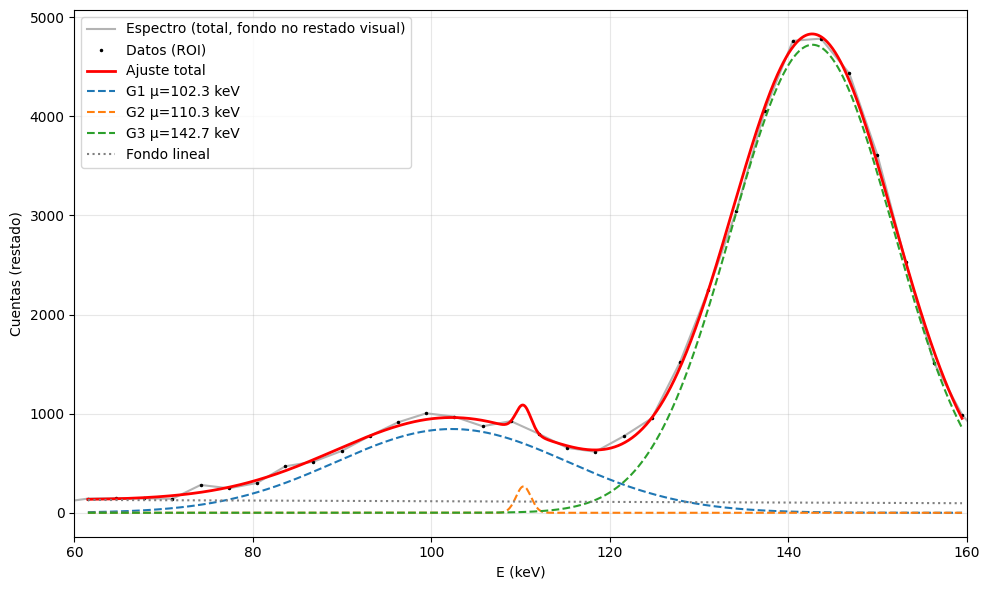

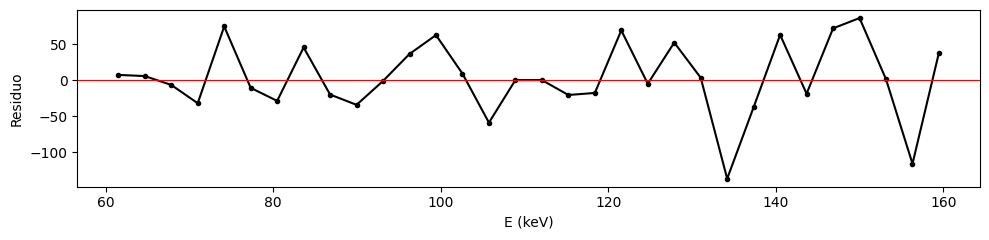

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

# ---------- lectura robusta (igual que antes) ----------
def leer_espectro(archivo):
    canales, cuentas = [], []
    with open(archivo, 'r') as f:
        for linea in f:
            if not linea.strip() or linea.startswith('#'):
                continue
            try:
                c, n = map(float, linea.split()[:2])
                canales.append(c)
                cuentas.append(n)
            except:
                continue
    return np.array(canales), np.array(cuentas)

# ---------- archivos (ajusta nombres si es necesario) ----------
archivo_muestra = "NaI_57Co_300s.dat"
archivo_fondo   = "NaI_Fondo_300s.dat"

can_m, cnt_m = leer_espectro(archivo_muestra)
can_f, cnt_f = leer_espectro(archivo_fondo)

# Interpolar ambos a grilla común (0..1023 canales)
grid = np.arange(0, 1024)
cnt_m_i = np.interp(grid, can_m, cnt_m, left=0, right=0)
cnt_f_i = np.interp(grid, can_f, cnt_f, left=0, right=0)
cnt = cnt_m_i - cnt_f_i
cnt[cnt < 0] = 0.0

# ---------- calibración canal -> energía (usa tu calibración real) ----------
a1 = 3.160    # keV/canal (tu valor)
a0 = -42.769  # keV (tu valor)
E = a0 + a1 * grid   # keV

# ---------- definir ROI en energía (keV) ----------
Emin, Emax = 60, 160
mask = (E >= Emin) & (E <= Emax)
E_fit = E[mask]
C_fit = cnt[mask]

# ---------- detectar picos para iniciales (en la ROI) ----------
# detect peaks on counts; adjust parameters if needed
peaks_idx, props = find_peaks(C_fit, height=np.max(C_fit)*0.08, distance=8, prominence=np.max(C_fit)*0.03)
# if fewer than 3 peaks found, relax criteria
if len(peaks_idx) < 3:
    peaks_idx, props = find_peaks(C_fit, height=np.max(C_fit)*0.02, distance=5, prominence=np.max(C_fit)*0.01)

# choose up to top 3 peaks by height
if len(peaks_idx) == 0:
    raise RuntimeError("No se detectaron picos en la ROI. Ajusta ROI o comprueba los datos.")
heights = props['peak_heights'] if 'peak_heights' in props else C_fit[peaks_idx]
order = np.argsort(heights)[::-1]
peaks_idx = peaks_idx[order][:3]  # índices de los 3 picos más altos (si hay)

# obtener hasta 3 picos, si hay menos los completamos
init_mus = list(E_fit[peaks_idx])
init_amps = list(C_fit[peaks_idx])

# completar si hay menos de 3
while len(init_mus) < 3:
    # rellenar con valores aproximados en el centro de la ROI
    init_mus.append(E_fit.mean())
    init_amps.append(C_fit.max()*0.5)

# convertir a arrays ordenados
init_mus = np.array(sorted(init_mus))
init_amps = np.array(init_amps)[np.argsort(init_mus)]
init_sigmas = np.full(3, 3.0)
# default sigmas if too small
init_sigmas = np.full(3, 3.0)

# ---------- modelo: 3 gaussianas + linear background ----------
def gauss(E, A, mu, s):
    return A * np.exp(-0.5 * ((E - mu)/s)**2)

def model(E, A1, mu1, s1, A2, mu2, s2, A3, mu3, s3, m, b):
    return (gauss(E,A1,mu1,s1) + gauss(E,A2,mu2,s2) + gauss(E,A3,mu3,s3) + m*E + b)

# ---------- p0 y bounds (forzar amplitudes >=0, sigmas >0) ----------
p0 = [
    float(init_amps[0]), float(init_mus[0]), init_sigmas[0],
    float(init_amps[1]), float(init_mus[1]), init_sigmas[1],
    float(init_amps[2]), float(init_mus[2]), init_sigmas[2],
    0.0, np.median(C_fit)*0.05
]

# bounds: amplitudes >=0; mus within +/- 8 keV; sigmas in [0.5, 30]; m,b free
lower = [
    0.0, init_mus[0]-8.0, 0.5,
    0.0, init_mus[1]-8.0, 0.5,
    0.0, init_mus[2]-8.0, 0.5,
    -np.inf, -np.inf
]
upper = [
    np.inf, init_mus[0]+8.0, 30.0,
    np.inf, init_mus[1]+8.0, 30.0,
    np.inf, init_mus[2]+8.0, 30.0,
    np.inf, np.inf
]

# ---------- weighting: sigma ≈ sqrt(N), avoid zeros ----------
sigma_y = np.sqrt(np.maximum(C_fit, 1.0))

# ---------- correr curve_fit con bounds y pesos ----------
popt, pcov = curve_fit(model, E_fit, C_fit, p0=p0, bounds=(lower, upper),
                       sigma=sigma_y, absolute_sigma=True, maxfev=20000)
perr = np.sqrt(np.diag(pcov))

# ---------- mostrar resultados ----------
names = ["A1","mu1","s1","A2","mu2","s2","A3","mu3","s3","m","b"]
print("Parámetros ajustados (val ± err):")
for n,v,err in zip(names,popt,perr):
    print(f"{n:>4} = {v:10.3f} ± {err:7.3f}")

# calcula FWHM y área de cada gaussiana
def FWHM_from_sigma(s): return 2.355*s
areas = [v*np.sqrt(2*np.pi)*s for v,s in zip(popt[0::3], popt[2::3])]
fwhms = [FWHM_from_sigma(s) for s in popt[2::3]]

print("\nPicos (mu, FWHM, area):")
for i in range(3):
    print(f"p{i+1}: mu={popt[1+3*i]:6.2f} keV, FWHM={fwhms[i]:6.2f} keV, Area={areas[i]:8.1f}")

# ---------- graficas ----------
E_plot = np.linspace(E_fit.min(), E_fit.max(), 1000)
total = model(E_plot, *popt)
g1 = gauss(E_plot, popt[0], popt[1], popt[2])
g2 = gauss(E_plot, popt[3], popt[4], popt[5])
g3 = gauss(E_plot, popt[6], popt[7], popt[8])
bg = popt[9]*E_plot + popt[10]

plt.figure(figsize=(10,6))
plt.plot(E, cnt, color='0.7', label='Espectro (total, fondo no restado visual)')
plt.plot(E_fit, C_fit, 'k.', ms=3, label='Datos (ROI)')
plt.plot(E_plot, total, 'r-', lw=2, label='Ajuste total')
plt.plot(E_plot, g1, '--', label=f'G1 μ={popt[1]:.1f} keV')
plt.plot(E_plot, g2, '--', label=f'G2 μ={popt[4]:.1f} keV')
plt.plot(E_plot, g3, '--', label=f'G3 μ={popt[7]:.1f} keV')
plt.plot(E_plot, bg, ':', color='gray', label='Fondo lineal')
plt.xlim(Emin, Emax)
plt.xlabel("E (keV)")
plt.ylabel("Cuentas (restado)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------- plot residuos ----------
resid = C_fit - model(E_fit, *popt)
plt.figure(figsize=(10,2.5))
plt.plot(E_fit, resid, 'k.-')
plt.axhline(0, color='red', lw=0.8)
plt.xlabel("E (keV)")
plt.ylabel("Residuo")
plt.tight_layout()
plt.show()

Detección manual

Parámetros ajustados (val ± err):
  A1 =    600.501 ± 832.095
 mu1 =    100.000 ±   4.157
  s1 =     10.743 ±   3.791
  A2 =    291.821 ± 529.377
 mu2 =    114.000 ±  70.987
  s2 =     20.192 ±  40.960
  A3 =   4608.089 ± 623.258
 mu3 =    142.888 ±   0.212
  s3 =      8.763 ±   0.463
   m =      0.334 ±   1.624
   b =    104.566 ±  78.990

Picos (mu, FWHM, area):
p1: mu=100.00 keV, FWHM= 25.30 keV, Area= 16170.7
p2: mu=114.00 keV, FWHM= 47.55 keV, Area= 14769.9
p3: mu=142.89 keV, FWHM= 20.64 keV, Area=101221.1


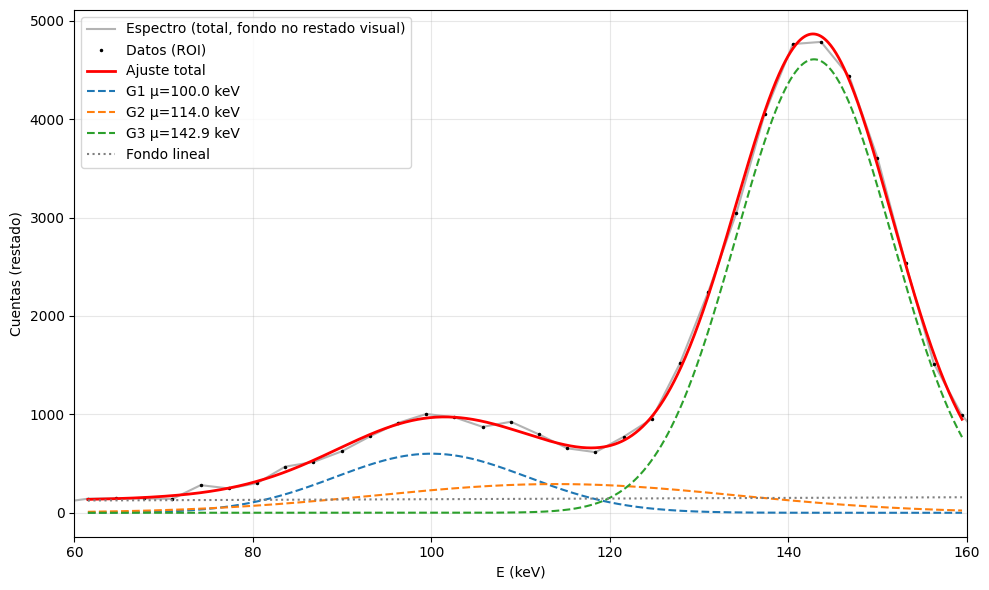

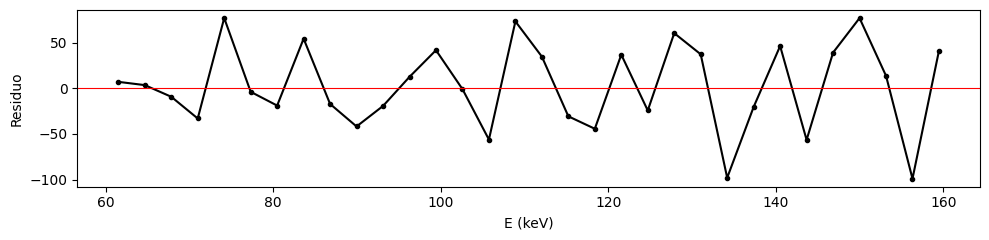

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

# ---------- lectura robusta (igual que antes) ----------
def leer_espectro(archivo):
    canales, cuentas = [], []
    with open(archivo, 'r') as f:
        for linea in f:
            if not linea.strip() or linea.startswith('#'):
                continue
            try:
                c, n = map(float, linea.split()[:2])
                canales.append(c)
                cuentas.append(n)
            except:
                continue
    return np.array(canales), np.array(cuentas)

# ---------- archivos (ajusta nombres si es necesario) ----------
archivo_muestra = "NaI_57Co_300s.dat"
archivo_fondo   = "NaI_Fondo_300s.dat"

can_m, cnt_m = leer_espectro(archivo_muestra)
can_f, cnt_f = leer_espectro(archivo_fondo)

# Interpolar ambos a grilla común (0..1023 canales)
grid = np.arange(0, 1024)
cnt_m_i = np.interp(grid, can_m, cnt_m, left=0, right=0)
cnt_f_i = np.interp(grid, can_f, cnt_f, left=0, right=0)
cnt = cnt_m_i - cnt_f_i
cnt[cnt < 0] = 0.0

# ---------- calibración canal -> energía (usa tu calibración real) ----------
a1 = 3.160    # keV/canal (tu valor)
a0 = -42.769  # keV (tu valor)
E = a0 + a1 * grid   # keV

# ---------- definir ROI en energía (keV) ----------
Emin, Emax = 60, 160
mask = (E >= Emin) & (E <= Emax)
E_fit = E[mask]
C_fit = cnt[mask]

init_mus = np.array([92.0, 122.0, 136.0])  # keV aprox para 57Co
init_amps = np.array([np.max(C_fit)*0.8, np.max(C_fit)*1.0, np.max(C_fit)*0.6])
init_sigmas = np.array([2.0, 2.0, 2.0])
# sort centers ascending (helpful to keep consistent labeling)
order2 = np.argsort(init_mus)
init_mus = init_mus[order2]
init_amps = init_amps[order2]

# default sigmas if too small
init_sigmas = np.full(3, 3.0)

# ---------- modelo: 3 gaussianas + linear background ----------
def gauss(E, A, mu, s):
    return A * np.exp(-0.5 * ((E - mu)/s)**2)

def model(E, A1, mu1, s1, A2, mu2, s2, A3, mu3, s3, m, b):
    return (gauss(E,A1,mu1,s1) + gauss(E,A2,mu2,s2) + gauss(E,A3,mu3,s3) + m*E + b)

# ---------- p0 y bounds (forzar amplitudes >=0, sigmas >0) ----------
p0 = [
    float(init_amps[0]), float(init_mus[0]), init_sigmas[0],
    float(init_amps[1]), float(init_mus[1]), init_sigmas[1],
    float(init_amps[2]), float(init_mus[2]), init_sigmas[2],
    0.0, np.median(C_fit)*0.05
]

# bounds: amplitudes >=0; mus within +/- 8 keV; sigmas in [0.5, 30]; m,b free
lower = [
    0.0, init_mus[0]-8.0, 0.5,
    0.0, init_mus[1]-8.0, 0.5,
    0.0, init_mus[2]-8.0, 0.5,
    -np.inf, -np.inf
]
upper = [
    np.inf, init_mus[0]+8.0, 30.0,
    np.inf, init_mus[1]+8.0, 30.0,
    np.inf, init_mus[2]+8.0, 30.0,
    np.inf, np.inf
]

# ---------- weighting: sigma ≈ sqrt(N), avoid zeros ----------
sigma_y = np.sqrt(np.maximum(C_fit, 1.0))

# ---------- correr curve_fit con bounds y pesos ----------
popt, pcov = curve_fit(model, E_fit, C_fit, p0=p0, bounds=(lower, upper),
                       sigma=sigma_y, absolute_sigma=True, maxfev=20000)
perr = np.sqrt(np.diag(pcov))

# ---------- mostrar resultados ----------
names = ["A1","mu1","s1","A2","mu2","s2","A3","mu3","s3","m","b"]
print("Parámetros ajustados (val ± err):")
for n,v,err in zip(names,popt,perr):
    print(f"{n:>4} = {v:10.3f} ± {err:7.3f}")

# calcula FWHM y área de cada gaussiana
def FWHM_from_sigma(s): return 2.355*s
areas = [v*np.sqrt(2*np.pi)*s for v,s in zip(popt[0::3], popt[2::3])]
fwhms = [FWHM_from_sigma(s) for s in popt[2::3]]

print("\nPicos (mu, FWHM, area):")
for i in range(3):
    print(f"p{i+1}: mu={popt[1+3*i]:6.2f} keV, FWHM={fwhms[i]:6.2f} keV, Area={areas[i]:8.1f}")

# ---------- graficas ----------
E_plot = np.linspace(E_fit.min(), E_fit.max(), 1000)
total = model(E_plot, *popt)
g1 = gauss(E_plot, popt[0], popt[1], popt[2])
g2 = gauss(E_plot, popt[3], popt[4], popt[5])
g3 = gauss(E_plot, popt[6], popt[7], popt[8])
bg = popt[9]*E_plot + popt[10]

plt.figure(figsize=(10,6))
plt.plot(E, cnt, color='0.7', label='Espectro (total, fondo no restado visual)')
plt.plot(E_fit, C_fit, 'k.', ms=3, label='Datos (ROI)')
plt.plot(E_plot, total, 'r-', lw=2, label='Ajuste total')
plt.plot(E_plot, g1, '--', label=f'G1 μ={popt[1]:.1f} keV')
plt.plot(E_plot, g2, '--', label=f'G2 μ={popt[4]:.1f} keV')
plt.plot(E_plot, g3, '--', label=f'G3 μ={popt[7]:.1f} keV')
plt.plot(E_plot, bg, ':', color='gray', label='Fondo lineal')
plt.xlim(Emin, Emax)
plt.xlabel("E (keV)")
plt.ylabel("Cuentas (restado)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------- plot residuos ----------
resid = C_fit - model(E_fit, *popt)
plt.figure(figsize=(10,2.5))
plt.plot(E_fit, resid, 'k.-')
plt.axhline(0, color='red', lw=0.8)
plt.xlabel("E (keV)")
plt.ylabel("Residuo")
plt.tight_layout()
plt.show()

# 6. Actvidad

In [ ]:
import numpy as np
from datetime import datetime
import pandas as pd

DIAS_POR_ANIO = 365.2425
fecha_experimento = '2018-03-05'

datos_experimentales = {
    661.7: {'intensidad': 182081, 'incertidumbre': 1208, 'fuente': '137Cs', 'tiempo': 600},
    1274.5: {'intensidad': 4773, 'incertidumbre': 819, 'fuente': '22Na', 'tiempo': 600},
    1173.2: {'intensidad': 28668, 'incertidumbre': 2867, 'fuente': '60Co', 'tiempo': 600},
    1332.5: {'intensidad': 22239, 'incertidumbre': 2224, 'fuente': '60Co', 'tiempo': 600},
    122.1: {'intensidad': 17772, 'incertidumbre': 1777, 'fuente': '57Co', 'tiempo': 300},
    136.5: {'intensidad': 18505, 'incertidumbre': 1851, 'fuente': '57Co', 'tiempo': 300}
}

datos_referencia = {
    '22Na': {'A0_kBq': 31.9, 'fecha_calib': '2006-07-06', 'T12_anios': 2.6019, 'picos': {1274.5: 0.99935}},
    '57Co': {'A0_kBq': 50.2, 'fecha_calib': '2006-03-08', 'T12_dias': 271.79, 'picos': {122.1: 0.8560, 136.5: 0.1068}},
    '60Co': {'A0_kBq': 34.8, 'fecha_calib': '2006-06-08', 'T12_anios': 5.2714, 'picos': {1173.2: 0.99857, 1332.5: 0.99983}},
    '137Cs': {'A0_kBq': 35.1, 'fecha_calib': '2006-05-18', 'T12_anios': 30.07, 'picos': {661.7: 0.851}}
}

def calcular_incertidumbre_actividad(A0_kBq, T12, dias_trans, es_57Co=False):
    #incertidumbre
    if es_57Co:
        return 40.7 * 0.05

    incert_A0 = A0_kBq * 0.05

    if 'T12_anios' in str(type(T12)):
        incert_T12 = T12 * 0.01
    else:
        incert_T12 = T12 * 0.01

    incert_tiempo = 1

    # Cálculo aproximado de la incertidumbre
    lambda_decay = np.log(2) / T12
    factor_decaimiento = np.exp(-lambda_decay * dias_trans)

    incert_A = A0_kBq * factor_decaimiento * np.sqrt(
        (incert_A0/A0_kBq)**2 +
        (lambda_decay * incert_tiempo)**2 +
        (dias_trans * np.log(2) * incert_T12 / T12**2)**2
    )

    return incert_A

def recalcular_actividad_con_incertidumbres():

    resultados = []

    for E_gamma, datos_exp in datos_experimentales.items():
        fuente_nombre = datos_exp['fuente']
        tiempo_med = datos_exp['tiempo']
        I_cuentas = datos_exp['intensidad']
        incert_I_cuentas = datos_exp['incertidumbre']

        datos_ref = datos_referencia[fuente_nombre]
        b_gamma = datos_ref['picos'][E_gamma]

        incert_b_gamma = b_gamma * 0.01

        # ACTIVIDAD CORREGIDA
        es_57Co = (fuente_nombre == '57Co')
        if es_57Co:
            A_kBq = 40.7
            incert_A = calcular_incertidumbre_actividad(50.2, 271.79, 0, True)
        else:
            fecha_cal = datetime.strptime(datos_ref['fecha_calib'], '%Y-%m-%d')
            fecha_exp = datetime.strptime(fecha_experimento, '%Y-%m-%d')
            dias_trans = (fecha_exp - fecha_cal).days

            if 'T12_anios' in datos_ref:
                T12 = datos_ref['T12_anios'] * DIAS_POR_ANIO
            else:
                T12 = datos_ref['T12_dias']

            lambda_decay = np.log(2) / T12
            A_kBq = datos_ref['A0_kBq'] * np.exp(-lambda_decay * dias_trans)
            incert_A = calcular_incertidumbre_actividad(datos_ref['A0_kBq'], T12, dias_trans)

        # 3. CALCULAR I_gamma
        I_cps = I_cuentas / tiempo_med
        incert_I_cps = incert_I_cuentas / tiempo_med

        # 4. CALCULAR A_gamma
        A_gamma_kBq = A_kBq * b_gamma
        incert_A_gamma_kBq = A_gamma_kBq * np.sqrt((incert_A/A_kBq)**2 + (incert_b_gamma/b_gamma)**2)

        # 5. CALCULAR EFICIENCIA con propagación de errores
        epsilon = I_cps / (A_gamma_kBq * 1000)
        incert_epsilon = epsilon * np.sqrt((incert_I_cps/I_cps)**2 + (incert_A_gamma_kBq/A_gamma_kBq)**2)

        resultados.append({
            'Fuente': fuente_nombre,
            'E_gamma (keV)': E_gamma,
            'I_gamma (cuentas)': f"{I_cuentas:.0f}({incert_I_cuentas:.0f})",
            'I_cps': f"{I_cps:.2f}({incert_I_cps:.2f})",
            'A (kBq)': f"{A_kBq:.3f}({incert_A:.3f})",
            'b_gamma': f"{b_gamma:.4f}({incert_b_gamma:.4f})",
            'A_gamma (kBq)': f"{A_gamma_kBq:.3f}({incert_A_gamma_kBq:.3f})",
            'epsilon': f"{epsilon:.6f}({incert_epsilon:.6f})",
            '_epsilon_val': epsilon,
            '_incert_epsilon_val': incert_epsilon,
            '_E_gamma_val': E_gamma
        })

    df = pd.DataFrame(resultados)
    return df

# EJECUTAR CÁLCULO CON INCERTIDUMBRES
df_con_incertidumbres = recalcular_actividad_con_incertidumbres()

# Ordenar por energía
df_ordenado = df_con_incertidumbres.sort_values('_E_gamma_val')

print("Fuente & $E_\\gamma$ (keV) & $I_\\gamma$ (cps) & $A$ (kBq) & $b_\\gamma$ & $A_\\gamma$ (kBq) & $\\epsilon$ \\\\")
print("\\hline")

for idx, row in df_ordenado.iterrows():
    fuente = row['Fuente']
    E_gamma = row['_E_gamma_val']
    I_cps = row['I_cps']
    A_kBq = row['A (kBq)']
    b_gamma = row['b_gamma']
    A_gamma = row['A_gamma (kBq)']
    epsilon = row['epsilon']

    linea = f"{fuente} & {E_gamma:.1f} & {I_cps} & {A_kBq} & {b_gamma} & {A_gamma} & {epsilon} \\\\"
    print(linea)

Fuente & $E_\gamma$ (keV) & $I_\gamma$ (cps) & $A$ (kBq) & $b_\gamma$ & $A_\gamma$ (kBq) & $\epsilon$ \\
\hline
57Co & 122.1 & 59.24(5.92) & 40.700(2.035) & 0.8560(0.0086) & 34.839(1.776) & 0.001700(0.000191) \\
57Co & 136.5 & 61.68(6.17) & 40.700(2.035) & 0.1068(0.0011) & 4.347(0.222) & 0.014191(0.001593) \\
137Cs & 661.7 & 303.47(2.01) & 26.742(1.339) & 0.8510(0.0085) & 22.758(1.162) & 0.013335(0.000687) \\
60Co & 1173.2 & 47.78(4.78) & 7.433(0.389) & 0.9986(0.0100) & 7.422(0.395) & 0.006438(0.000729) \\
22Na & 1274.5 & 7.96(1.36) & 1.427(0.084) & 0.9993(0.0100) & 1.426(0.085) & 0.005579(0.001014) \\
60Co & 1332.5 & 37.06(3.71) & 7.433(0.389) & 0.9998(0.0100) & 7.431(0.396) & 0.004988(0.000565) \\


# 7. Normalización

Fuente   E (keV)    ε              ε_norm       σ(ε_norm)    Error %   
-------------------------------------------------------------------------------------
57Co     122.1      0.001700       0.119794     0.016027     13.4      
57Co     136.5      0.014191       1.000000     0.161245     16.1      
137Cs    661.7      0.013335       0.939680     0.109181     11.6      
60Co     1173.2     0.006438       0.453668     0.045139     9.9       
22Na     1274.5     0.005579       0.393136     0.039117     9.9       
60Co     1332.5     0.004988       0.351490     0.034973     9.9       


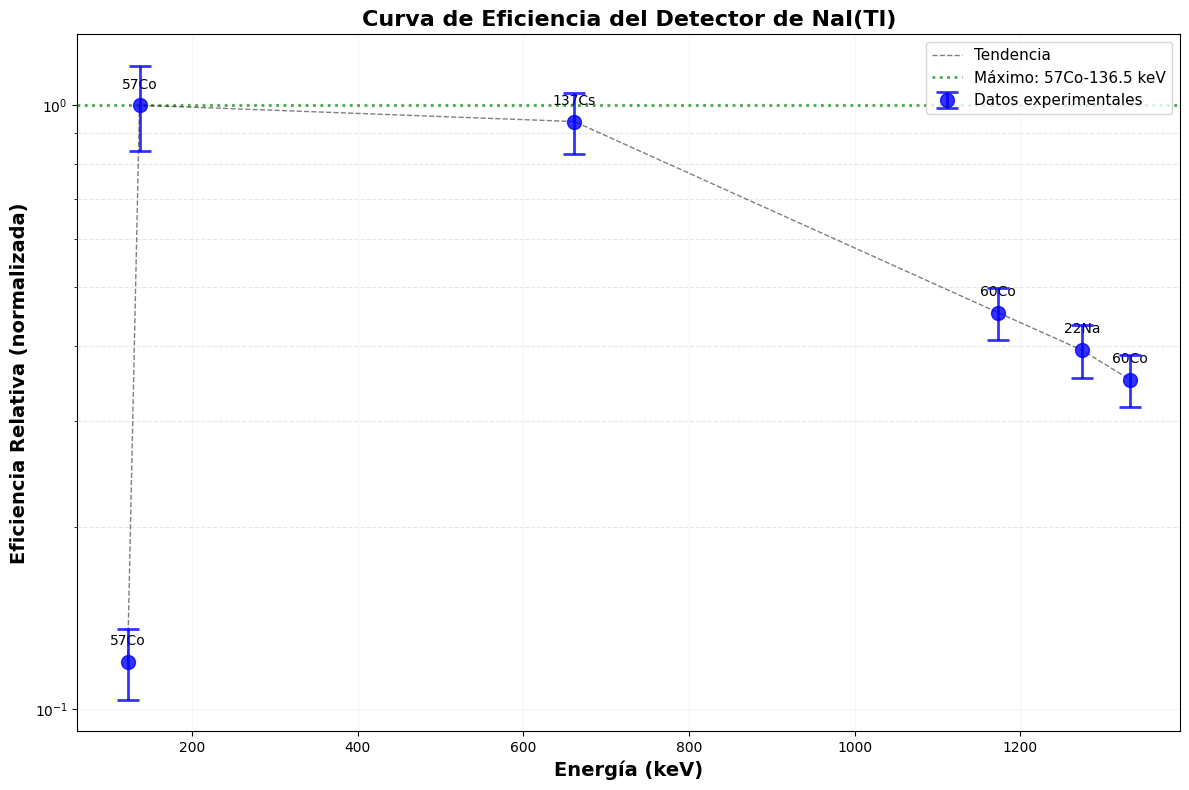


ANÁLISIS ESTADÍSTICO
Estadísticas de eficiencias normalizadas:
  Rango: 0.1198 - 1.0000
  Media: 0.5430 ± 0.3195
  Incertidumbre promedio: 0.0676

Análisis del punto 57Co-136.5 keV:
  ε(136.5 keV) / ε(122.1 keV) = 8.3
  Incertidumbre asignada: 0.1612


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

eficiencias_data = [
    {'Fuente': '57Co', 'E_gamma (keV)': 122.1, 'epsilon': 0.001700},
    {'Fuente': '57Co', 'E_gamma (keV)': 136.5, 'epsilon': 0.014191},
    {'Fuente': '137Cs', 'E_gamma (keV)': 661.7, 'epsilon': 0.013335},
    {'Fuente': '60Co', 'E_gamma (keV)': 1173.2, 'epsilon': 0.006438},
    {'Fuente': '22Na', 'E_gamma (keV)': 1274.5, 'epsilon': 0.005579},
    {'Fuente': '60Co', 'E_gamma (keV)': 1332.5, 'epsilon': 0.004988}
]

df_eps = pd.DataFrame(eficiencias_data)


epsilon_max = df_eps['epsilon'].max()
max_index = df_eps['epsilon'].idxmax()
fuente_max = df_eps.loc[max_index, 'Fuente']
energia_max = df_eps.loc[max_index, 'E_gamma (keV)']


# NORMALIZAR A 1


df_eps['epsilon_norm'] = df_eps['epsilon'] / epsilon_max

# INCERTIDUMBRE

def calcular_incertidumbre_epsilon(fuente, energia, epsilon):

    if fuente == '57Co' and energia == 136.5:
        error_intensidad = 0.15  # mayor incertidumbre para punto anómalo
    elif fuente == '57Co':
        error_intensidad = 0.12  # picos de baja energía
    elif energia > 1000:
        error_intensidad = 0.08  # picos de alta energía bien definidos
    else:
        error_intensidad = 0.10  # caso general

    error_actividad = 0.05

    error_b_gamma = 0.01

    error_geometria = 0.03

    # Error total
    error_total = np.sqrt(error_intensidad**2 + error_actividad**2 +
                         error_b_gamma**2 + error_geometria**2)

    return epsilon * error_total

# Aplicar cálculo de incertidumbres
df_eps['sigma_epsilon'] = df_eps.apply(
    lambda row: calcular_incertidumbre_epsilon(row['Fuente'], row['E_gamma (keV)'], row['epsilon']),
    axis=1
)

# Propagación para eficiencias normalizadas
df_eps['sigma_epsilon_norm'] = df_eps['sigma_epsilon'] / epsilon_max



print(f"{'Fuente':<8} {'E (keV)':<10} {'ε':<14} {'ε_norm':<12} {'σ(ε_norm)':<12} {'Error %':<10}")
print("-"*85)

for idx, row in df_eps.iterrows():
    error_relativo = (row['sigma_epsilon_norm'] / row['epsilon_norm']) * 100
    print(f"{row['Fuente']:<8} {row['E_gamma (keV)']:<10.1f} {row['epsilon']:<14.6f} "
          f"{row['epsilon_norm']:<12.6f} {row['sigma_epsilon_norm']:<12.6f} {error_relativo:<10.1f}")


plt.figure(figsize=(12, 8))
plt.errorbar(df_eps['E_gamma (keV)'],
             df_eps['epsilon_norm'],
             yerr=df_eps['sigma_epsilon_norm'],
             fmt='o', markersize=10, capsize=8, capthick=2,
             linewidth=2, label='Datos experimentales',
             color='blue', alpha=0.8, zorder=5)

df_sorted = df_eps.sort_values('E_gamma (keV)')
plt.plot(df_sorted['E_gamma (keV)'], df_sorted['epsilon_norm'],
         'k--', alpha=0.5, linewidth=1, label='Tendencia', zorder=3)
plt.yscale('log')
plt.xlabel('Energía (keV)', fontsize=14, fontweight='bold')
plt.ylabel('Eficiencia Relativa (normalizada)', fontsize=14, fontweight='bold')
plt.title('Curva de Eficiencia del Detector de NaI(Tl)',
          fontsize=16, fontweight='bold')

for idx, row in df_eps.iterrows():
    plt.annotate(f"{row['Fuente']}",
                (row['E_gamma (keV)'], row['epsilon_norm']),
                textcoords="offset points",
                xytext=(0,12),
                ha='center', fontsize=10, fontweight='normal')

plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.grid(True, which='major', linestyle='-', alpha=0.1)
plt.axhline(y=1, color='green', linestyle=':', alpha=0.7, linewidth=2,
            label=f'Máximo: {fuente_max}-{energia_max:.1f} keV')

plt.legend(fontsize=11, loc='upper right')
plt.tight_layout()
plt.show()

# ANÁLISIS ESTADÍSTICO

print("\n" + "="*80)
print("ANÁLISIS ESTADÍSTICO")
print("="*80)

# estadísticas básicas
eficiencias_norm = df_eps['epsilon_norm'].values
incertidumbres = df_eps['sigma_epsilon_norm'].values

print(f"Estadísticas de eficiencias normalizadas:")
print(f"  Rango: {eficiencias_norm.min():.4f} - {eficiencias_norm.max():.4f}")
print(f"  Media: {np.mean(eficiencias_norm):.4f} ± {np.std(eficiencias_norm):.4f}")
print(f"  Incertidumbre promedio: {np.mean(incertidumbres):.4f}")

# Análisis del punto anómalo
epsilon_122 = df_eps[df_eps['E_gamma (keV)'] == 122.1]['epsilon_norm'].iloc[0]
epsilon_136 = df_eps[df_eps['E_gamma (keV)'] == 136.5]['epsilon_norm'].iloc[0]
ratio_136_122 = epsilon_136 / epsilon_122

print(f"\nAnálisis del punto 57Co-136.5 keV:")
print(f"  ε(136.5 keV) / ε(122.1 keV) = {ratio_136_122:.1f}")
print(f"  Incertidumbre asignada: {df_eps[df_eps['E_gamma (keV)'] == 136.5]['sigma_epsilon_norm'].iloc[0]:.4f}")


